In [29]:

import jax
import os



os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '1.0'
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
print(jax.local_devices())



import jax
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import random, vmap, jit, grad
import jax.scipy as scipy

from jax import random


import matplotlib.pyplot as plt

from utils_rough_pde import *
from utils_elliptic_coef import *

from scipy import integrate

import time

from jax.numpy import fft

from tqdm import tqdm

import math

from jax import grad

from scipy import integrate

[cuda(id=0)]


In [30]:
from jax import jit, grad, vmap, hessian, value_and_grad
import optax

In [31]:
#plt.style.use('default')
plt.style.use('plot_style-Examples_3d.txt')

# 16:9 aspect ratio
width = 4
height = width * 3 / 4

In [32]:
# Testing the sine transform
def discrete_sine_transform(y):
    n = y.shape[0]
    y_extended = jnp.concatenate([y,  -y[::-1]])
    y_fft = fft.rfft(y_extended)
    return (-y_fft.imag/(jnp.sqrt(2)*(n)))[:-1] # Removing the last spurious element 

vmap_dst = jit(vmap(discrete_sine_transform, in_axes=(0,)))
@jit
def dst_2d(A):
    # Receives a 2d array and returns the 2d discrete sine transform
    return vmap_dst(vmap_dst(A).T).T


vmap_dst_2d = jit(vmap(dst_2d, in_axes = 0))#jit(vmap(vmap(dst_2d, in_axes=0, out_axes=0), in_axes=1,out_axes=1))
@jit
def double_dst_2d(A):
    # Transform along the last 2 axes
    A = vmap(vmap(dst_2d, in_axes=0, out_axes=0), in_axes=1,out_axes=1)(A)
    # Transpose the axes
    A = jnp.transpose(A, (2, 3, 0, 1))
    # Transform along the last 2 axes
    A = vmap(vmap(dst_2d, in_axes=0, out_axes=0), in_axes=1,out_axes=1)(A)
    # Transpose the axes (going back to the original order)
    A = jnp.transpose(A, (2, 3, 0,1))
    return A



def compute_2d_error(pred, u, x, y):
    norm_u = jnp.sqrt(integrate.trapezoid(integrate.trapezoid(u**2, x), y))
    norm_diff = jnp.sqrt(integrate.trapezoid(integrate.trapezoid((pred - u)**2, x), y))
    return norm_diff, norm_diff/norm_u

def create_interior(x, y):
    # Use meshgrid to create the grid of pairs
    A, B = jnp.meshgrid(x, y, indexing='ij')

    # Combine A and B into pairs
    interior = jnp.stack((A, B), axis=-1).reshape(-1, 2)
    return interior

In [33]:
def evaluate_function_sine_2d(x, y, k,l ,c):
    values = c*jnp.outer(jnp.sqrt(2)*jnp.sin(jnp.pi*k*x), jnp.sqrt(2)*jnp.sin(jnp.pi*l*y))
    values = jnp.where(k==0, c*jnp.outer(jnp.ones_like(x), jnp.sqrt(2)*jnp.sin(jnp.pi*l*y)), values)
    values = jnp.where(l==0, c*jnp.outer(jnp.sqrt(2)*jnp.sin(jnp.pi*k*x), jnp.ones_like(y)), values)
    return values
def evaluate_basis_sine_2d(x,y,c):
    # The frequency starts at 0
    f_1 = jnp.arange(0, c.shape[0])
    f_2 = jnp.arange(0, c.shape[0])
    return jnp.sum(jit(vmap(vmap(evaluate_function_sine_2d, in_axes=(None,None,0,None, 0), out_axes= -1), in_axes= (None, None, None, 0, 1),out_axes= -1))(x, y,f_1, f_2, c), axis = (2,3))#jit(vmap(vmap(evaluate_function_sine_2d, in_axes=(None,None,None,0, 1)), in_axes= (None, None, 0, None, 0)))(x, y,f_1, f_2, c)#vmap(evaluate_function_sine_2d, in_axes=(None,None,0,0, 0))(x, y,f_1, f_2, c)


def evaluate_function_sine_2d_iterative(x,y,c):
    values = jnp.zeros_like(jnp.outer(x, y))
    for k in range(c.shape[0]):
        for l in range(c.shape[1]):
            values += c[k,l]*jnp.outer(jnp.sqrt(2)*jnp.sin(jnp.pi*k*x), jnp.sqrt(2)*jnp.sin(jnp.pi*l*y))
    return values

In [34]:
# Define the neural network
def init_params(layer_sizes, key):
    params = []
    keys = random.split(key, len(layer_sizes))
    for m, n, key in zip(layer_sizes[:-1], layer_sizes[1:], keys):
        weights = random.normal(key, (m, n)) * jnp.sqrt(2 / m)
        biases = jnp.zeros(n)
        params.append((weights, biases))
    return params

def init_glorot_normal_params(layer_sizes, key):
    params = []
    keys = random.split(key, len(layer_sizes))
    for m, n, key in zip(layer_sizes[:-1], layer_sizes[1:], keys):
        stddev = jnp.sqrt(2.0 / (m + n))
        weights = stddev * random.normal(key, (m, n))
        biases = jnp.zeros(n)
        params.append((weights, biases))
    return params

def init_glorot_params(layer_sizes, key):
    params = []
    keys = random.split(key, len(layer_sizes))
    for m, n, key in zip(layer_sizes[:-1], layer_sizes[1:], keys):
        glorot_scale = jnp.sqrt(6.0 / (m + n))
        weights = random.uniform(key, (m, n), minval=-glorot_scale, maxval=glorot_scale)
        biases = jnp.zeros(n)
        params.append((weights, biases))
    return params


def predict(params, x):
    activations = x
    for weights, biases in params[:-1]:
        activations = jnp.tanh(jnp.dot(activations, weights) + biases)
    final_weights, final_biases = params[-1]
    return jnp.squeeze(jnp.dot(activations, final_weights) + final_biases)

In [35]:
def count_parameters(params):
    total_params = 0
    for weights, biases in params:
        total_params += weights.size
        total_params += biases.size
    return total_params

# Semilinear example


We will consider the problem 

\begin{aligned}
 -\nu \Delta u + c \sin(\beta 2\pi u) &= \xi \quad x \in \Omega\\
u &= 0 \quad x \in \partial \Omega
\end{aligned}

with a manufactured solution 


\begin{aligned}
u = \sum_{k=1}^\infty\sum_{l=1}^\infty \frac{u_{kl}}{(k^2 + l^2)^{\alpha + \delta}} \sin(\pi k x) \sin(\pi l y) \quad  u_{kl} \sim \mathcal{N}(0, 1)
\end{aligned}


In [36]:
lower = 0.0
upper = 1.0
domain = jnp.array([lower,upper])

In [37]:
key = random.PRNGKey(558)

n_coef = 2**7
print("Number of coefficients: ", n_coef)

c = 1.0
beta = 0.5

nu = 1e-1
#b = jit(lambda x, y: jnp.cos(5*jnp.pi*(x**2 + y**4)) + x**2 + jnp.exp(-y**2)+ 1.5)
b = lambda x,y: 0.0
vmap_b = jit(vmap(vmap(b, in_axes = (None, 0)), in_axes = (0, None)))


x_finest = jnp.linspace(lower,upper,n_coef, endpoint=False)
y_finest = jnp.linspace(lower,upper,n_coef, endpoint=False)
X, Y = jnp.meshgrid(x_finest, y_finest)
# Use meshgrid to create the grid of pairs
A, B = jnp.meshgrid(x_finest, y_finest, indexing='ij')
interior_finest = jnp.stack((A, B), axis=-1).reshape(-1, 2)



frequencies = jnp.arange(0, n_coef)

delta = .15
alpha = 1.
random_draw =  random.normal(key, shape= (n_coef,n_coef))
decay = (jnp.arange(0,n_coef)[None]**2 + jnp.arange(0,n_coef)[:,None]**2)
coef_u =random_draw*(decay)**(-alpha -delta)
coef_u= coef_u.at[:,0].set(0)
coef_u= coef_u.at[0,:].set(0)
coef_laplacian =coef_u*((nu*jnp.pi**2*decay))



Number of coefficients:  128


In [38]:
tau = jit(lambda x: c*jnp.sin(beta*2*jnp.pi*x))
tau_prime = jit(lambda x: c*jnp.cos(beta*2*jnp.pi*x)*beta*2*jnp.pi)

In [39]:
u_values = evaluate_basis_sine_2d(x_finest,y_finest, coef_u)
f_values =evaluate_basis_sine_2d(x_finest,y_finest, coef_laplacian) + vmap_b(x_finest, y_finest)*u_values + tau(u_values) #c*jnp.sin(beta*2*jnp.pi*u_values)

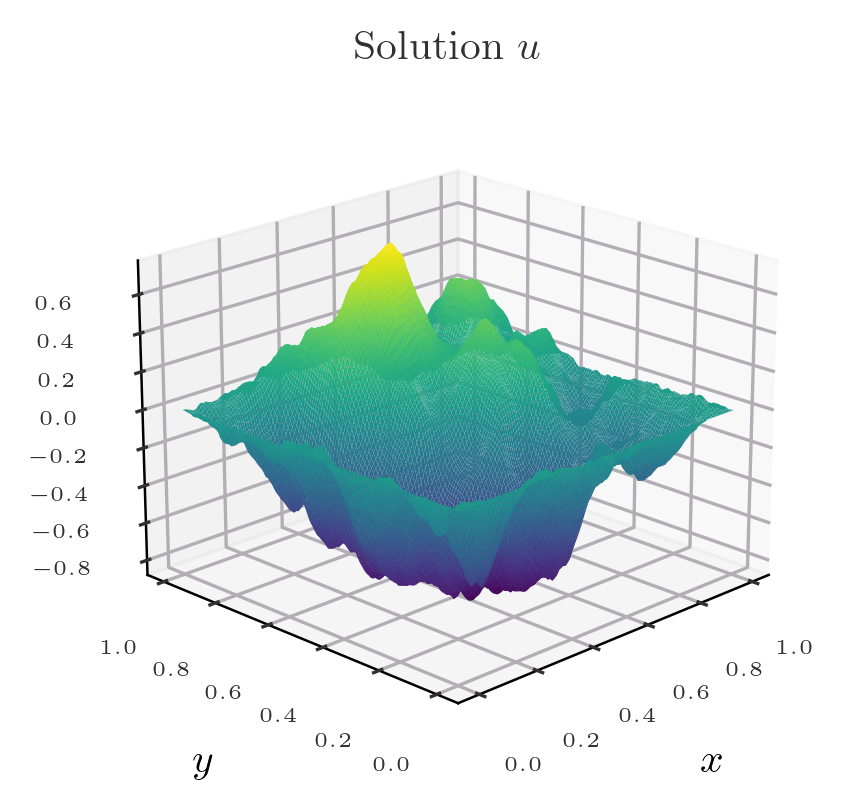

In [40]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, u_values,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"Solution $u$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

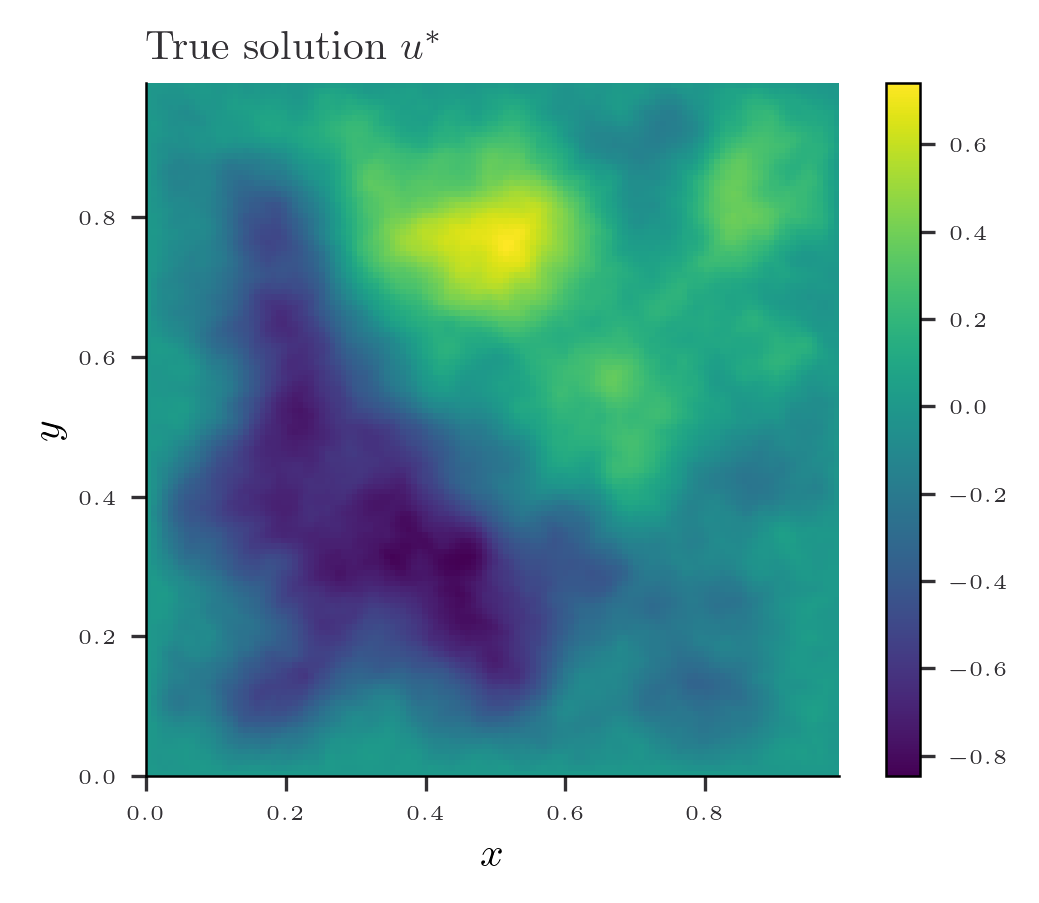

In [41]:
fig = plt.figure(figsize=(width, height))

plt.imshow(u_values[::-1, :], cmap='viridis', extent=[x_finest.min(), x_finest.max(), y_finest.min(), y_finest.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'True solution $u^*$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

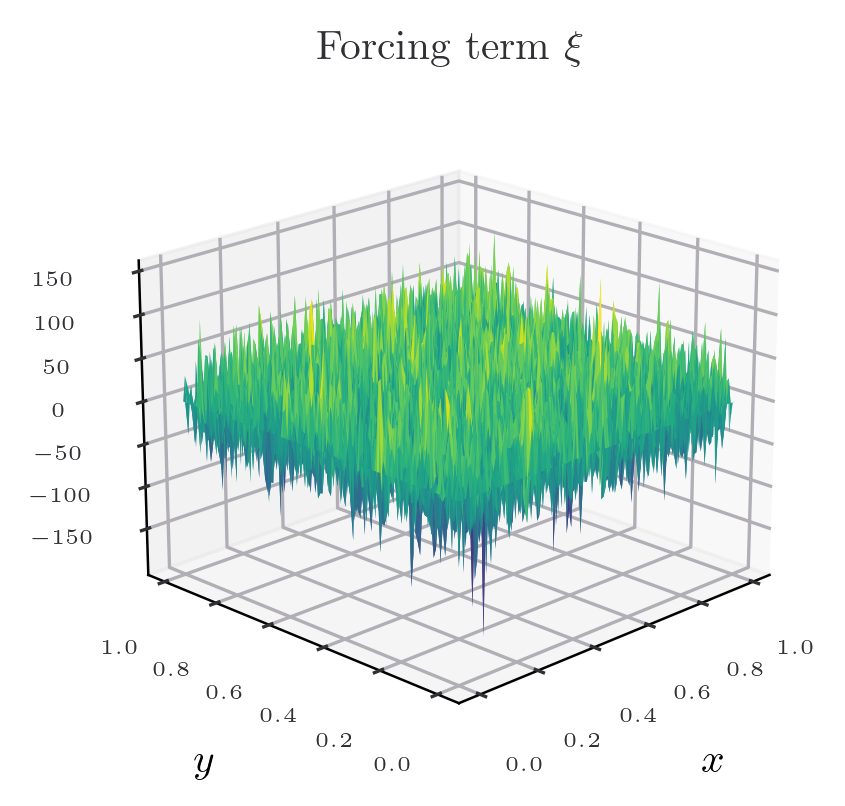

In [42]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, f_values,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"Forcing term $\xi$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

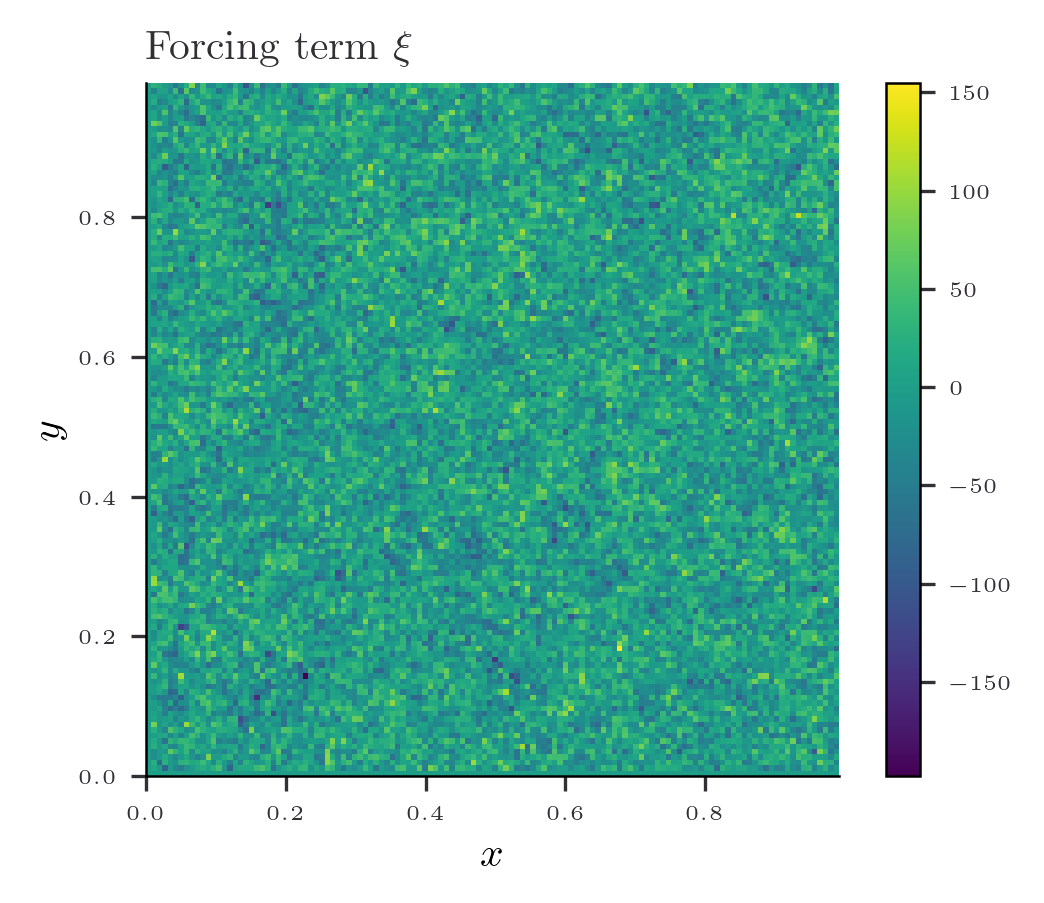

In [43]:
fig = plt.figure(figsize=(width, height))

plt.imshow(f_values[::-1, :], cmap='viridis', extent=[x_finest.min(), x_finest.max(), y_finest.min(), y_finest.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Forcing term $\xi$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

In [44]:
u_trans = dst_2d(u_values)
f_trans = dst_2d(f_values)
print(jnp.mean(jnp.abs(u_trans- coef_u)))

3.6245722661677274e-05


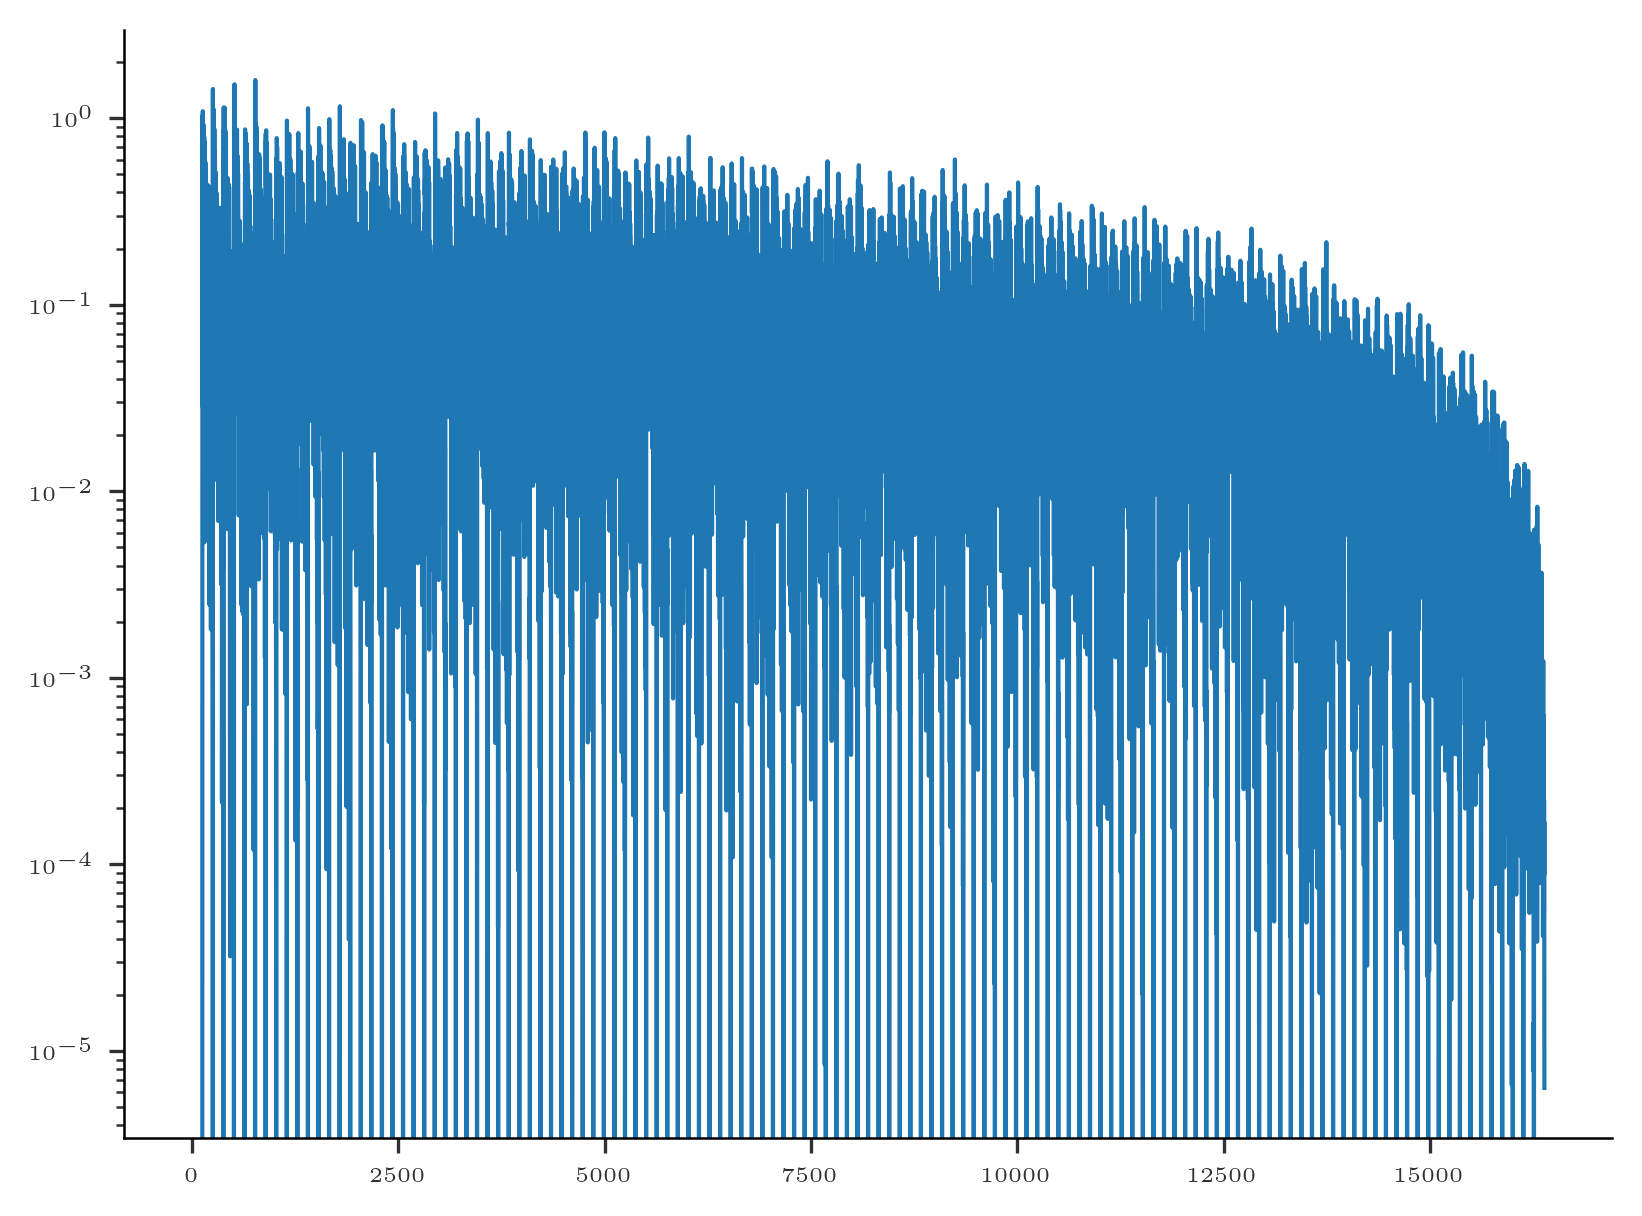

In [45]:
plt.plot(jnp.abs(f_trans.reshape(-1)), label = "f")
plt.yscale("log")
plt.show()

In [46]:
lower = 0.0
upper = 1.0
domain = jnp.array([lower,upper])


# 2d grid 
n_points = 2**6
print("Number of points {} ({} measurements)".format(n_points, n_points**2))
x = jnp.linspace(lower, upper, n_points, endpoint=False)
y = jnp.linspace(lower, upper, n_points, endpoint=False)
X, Y = jnp.meshgrid(x, y)

interior = create_interior(x, y)

Number of points 64 (4096 measurements)


In [47]:
# Create the boundary
n_boundary = 2**7
print("Number of boundary points: {} ({} total)".format(n_boundary, n_boundary*4))

# Create a boundary
# Boundary points
boundary = jnp.linspace(0,1, n_boundary)

boundary_points = []
# Creat a discretization of the boundary
for i in [0,1]:
    boundary_points.append(jnp.stack([jnp.zeros(n_boundary) + i, boundary], axis=-1))
for i in [0,1]:
    boundary_points.append(jnp.stack([boundary, jnp.zeros(n_boundary) + i], axis=-1))
    

boundary_points = jnp.concatenate(boundary_points, axis=0)
boundary_condition = jnp.zeros(shape = boundary_points.shape[0])

Number of boundary points: 128 (512 total)


# PINN solution: standard initialization

In [20]:
decay_nugget =  ((jnp.arange(0,n_points)[None]**2 + jnp.arange(0,n_points)[:,None]**2) + 1.0)**(-0.5)
decay_nugget

Array([[1.        , 0.70710678, 0.4472136 , ..., 0.01639124, 0.01612693,
        0.01587102],
       [0.70710678, 0.57735027, 0.40824829, ..., 0.01638904, 0.01612484,
        0.01586902],
       [0.4472136 , 0.40824829, 0.33333333, ..., 0.01638244, 0.01611855,
        0.01586303],
       ...,
       [0.01639124, 0.01638904, 0.01638244, ..., 0.01159114, 0.01149653,
        0.01140272],
       [0.01612693, 0.01612484, 0.01611855, ..., 0.01149653, 0.01140421,
        0.01131262],
       [0.01587102, 0.01586902, 0.01586303, ..., 0.01140272, 0.01131262,
        0.01122321]], dtype=float64, weak_type=True)

In [22]:
layer_sizes = [2, 64, 64,  1]
key = random.PRNGKey(0)
params = init_params(layer_sizes, key)
print("There are {} parameters in the neural network.".format(count_parameters(params)))


neural_network = jit(vmap(predict, in_axes=(None, 0)))


def laplacian(params, x):
    return jnp.trace(hessian(predict, argnums=-1)(params, x))

nn_laplacian = jit(vmap(laplacian, in_axes = (None, 0)))


# Define the loss function
def loss_fn(params, grid, boundary, f, boundary_conditions, nu, n_points, w = 1.0):
    u_grid = neural_network(params, grid).reshape(n_points, n_points)
    non_linearity = tau(u_grid)
    laplacian_grid = nn_laplacian(params, grid).reshape(n_points, n_points)
    # Compute the sine transform
    pred_sine = dst_2d(-nu*laplacian_grid + non_linearity)
    residual_interior = (pred_sine - f)*decay_nugget

    pred_boundary = neural_network(params, boundary)
    residual_boundary = pred_boundary - boundary_conditions
    return w*jnp.mean(residual_interior**2) + jnp.mean(residual_boundary**2)

There are 4417 parameters in the neural network.


In [23]:
params

[(Array([[ 0.36631509,  1.78017492,  1.44084002,  1.32152944,  0.17689652,
          -1.71681703, -1.23769718,  0.06346429,  0.59558091,  2.24786289,
           0.15279735, -0.11137205, -1.03634642, -2.28205839, -0.18546317,
          -1.0043416 ,  0.42483215,  0.31264413,  0.05031921, -0.64603136,
           0.44345679,  0.22883601, -0.09010079, -0.04510869,  1.06446444,
           0.03101281,  0.70278332,  0.57346558, -0.61417737, -0.20295322,
           0.75353913,  0.18305363,  1.48066668,  1.56462515, -1.16139666,
          -1.12271733, -0.03092135,  1.8447313 ,  0.12480288, -0.63757681,
           1.13795725, -1.24926756, -1.13808077, -0.72429144,  1.02944392,
          -0.85818998,  0.3085653 , -0.53213821,  2.1374072 ,  0.86788606,
          -0.23598866,  1.76338992, -0.9559512 ,  0.86301946,  0.07337624,
           0.59951245,  0.9612421 , -0.34900657, -0.13414531,  0.8024354 ,
          -0.80175758, -1.57610645, -1.87578506, -1.0051459 ],
         [ 0.15681639, -1.69495076, -

In [26]:
f_observed =  f_trans[:n_points,:n_points]

In [27]:
loss, grads = value_and_grad(loss_fn)(params, interior, boundary_points, f_observed, boundary_condition, nu, n_points, w = 1.0)
print(loss, grads)

0.0655723922283224 [(Array([[ 2.06034768e-03,  4.52995960e-03, -8.94928741e-03,
        -1.11508174e-02, -1.00823632e-02, -8.12865812e-03,
         9.68640391e-03,  4.10541693e-03, -2.72123654e-03,
        -1.90775454e-04,  4.25383104e-03, -1.99722528e-03,
        -8.43721379e-03, -7.04374334e-05, -2.63266097e-03,
        -2.96090160e-03, -5.28231205e-03, -6.71009071e-03,
         1.41220649e-04, -7.62742288e-04,  5.69123184e-03,
         2.59260001e-03, -1.96894144e-03,  3.95729234e-03,
        -1.18910915e-03,  2.07565218e-03, -5.57256002e-03,
         8.30775933e-04,  1.44055194e-03, -7.43774577e-03,
        -6.10598207e-03, -2.64240569e-04,  4.38856992e-04,
        -5.29337495e-03,  2.00547578e-03, -3.75796630e-03,
        -3.72924299e-04,  1.61403202e-03, -5.60443912e-03,
         4.84756850e-03, -3.59820019e-04, -1.82717536e-03,
        -4.16192677e-03, -5.94998505e-03, -5.10532490e-03,
         3.94680713e-05,  5.56599166e-03, -5.73158489e-03,
         2.93910680e-04,  2.0806769

In [24]:
# Define the learning rate scheduler
initial_learning_rate = 1e-3
num_epochs = 3e5
decay_steps = num_epochs/10
decay_rate = 0.9

learning_rate_schedule = optax.exponential_decay(
    init_value=initial_learning_rate,
    transition_steps=decay_steps,
    decay_rate=decay_rate,
    transition_begin=0,
    staircase=False
)
optimizer = optax.adam(learning_rate_schedule)
opt_state = optimizer.init(params)

In [25]:
@jit
def train_step(params, opt_state):
    loss, grads = value_and_grad(loss_fn)(params, interior, boundary_points, f_observed, boundary_condition, nu, n_points)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss


In [26]:
patience = jnp.inf  # Number of epochs to wait for improvement
best_loss = float('inf')
epochs_without_improvement = 0

In [27]:
loss_hist = []
for epoch in range(int(num_epochs)):
    params, opt_state, loss = train_step(params, opt_state)
    if epoch % 1e4 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.7f}')
    loss_hist.append(loss)

    if epoch % decay_steps == 0:
        current_learning_rate = learning_rate_schedule(epoch)
        print(f'Step {epoch}, Training Loss: {loss:.7f}, Learning Rate: {current_learning_rate:.6f}')

    if loss < best_loss:
        best_loss = loss
        epochs_without_improvement = 0
        #best_param = params.copy()
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f'Early stopping at epoch {epoch}')
        break

Epoch 0, Loss: 0.0655724
Step 0, Training Loss: 0.0655724, Learning Rate: 0.001000
Epoch 10000, Loss: 0.0002871
Epoch 20000, Loss: 0.0002111
Epoch 30000, Loss: 0.0001847
Step 30000, Training Loss: 0.0001847, Learning Rate: 0.000900
Epoch 40000, Loss: 0.0001683
Epoch 50000, Loss: 0.0001720
Epoch 60000, Loss: 0.0001491
Step 60000, Training Loss: 0.0001491, Learning Rate: 0.000810
Epoch 70000, Loss: 0.0001390
Epoch 80000, Loss: 0.0001303
Epoch 90000, Loss: 0.0001554
Step 90000, Training Loss: 0.0001554, Learning Rate: 0.000729
Epoch 100000, Loss: 0.0001172
Epoch 110000, Loss: 0.0001076
Epoch 120000, Loss: 0.0000998
Step 120000, Training Loss: 0.0000998, Learning Rate: 0.000656
Epoch 130000, Loss: 0.0000949
Epoch 140000, Loss: 0.0000910
Epoch 150000, Loss: 0.0000871
Step 150000, Training Loss: 0.0000871, Learning Rate: 0.000590
Epoch 160000, Loss: 0.0000834
Epoch 170000, Loss: 0.0000811
Epoch 180000, Loss: 0.0000796
Step 180000, Training Loss: 0.0000796, Learning Rate: 0.000531
Epoch 19000

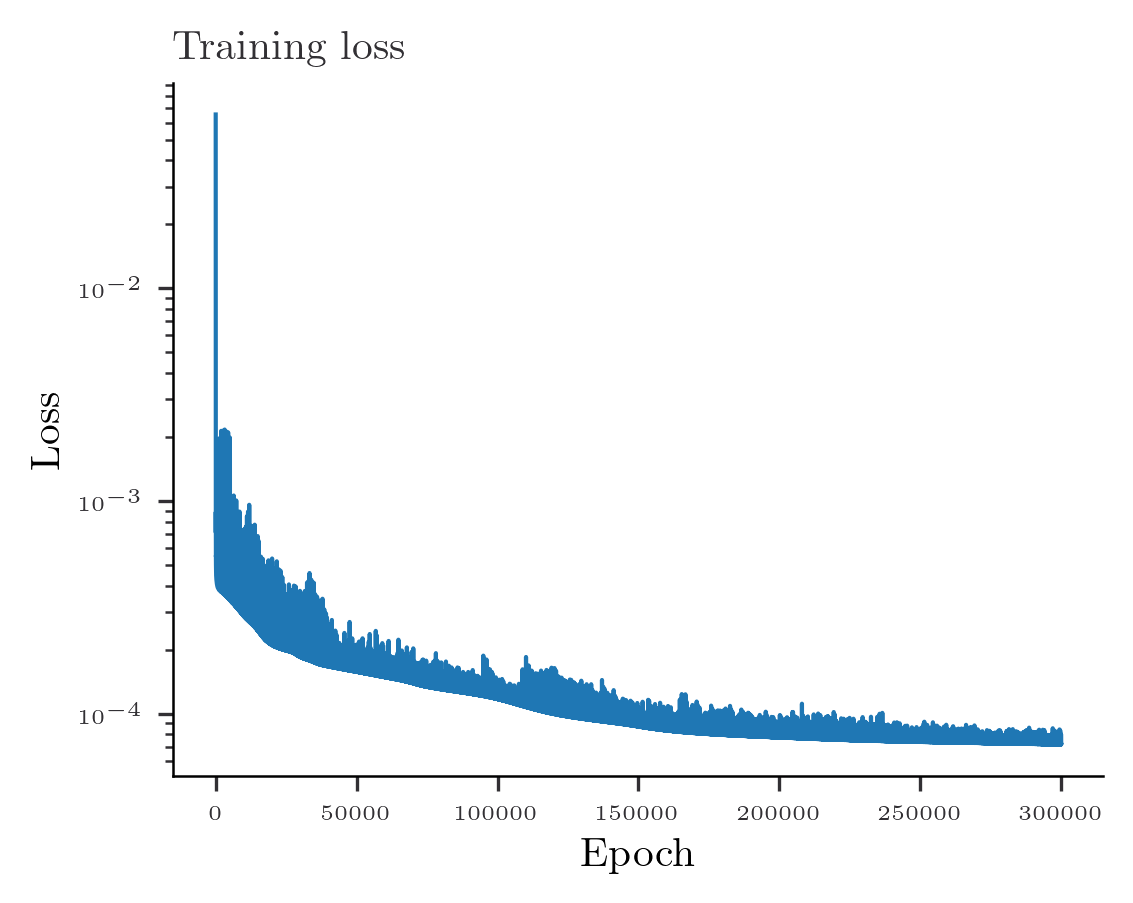

In [28]:
fig = plt.figure(figsize=(width, height))
plt.plot(loss_hist)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

In [28]:
n_eval = n_coef
x_eval = jnp.linspace(lower, upper, n_eval)
y_eval = jnp.linspace(lower, upper, n_eval)
X, Y = jnp.meshgrid(x_eval, y_eval)
interior_eval = create_interior(x_eval, y_eval)
u_eval =evaluate_basis_sine_2d(x_eval,y_eval, coef_u)

In [30]:
pred_grid = neural_network(params, interior_eval).reshape(n_eval, n_eval)

In [32]:
print(compute_2d_error(pred_grid, u_eval, x_eval, y_eval))

(Array(0.03431428, dtype=float64), Array(0.10564176, dtype=float64))


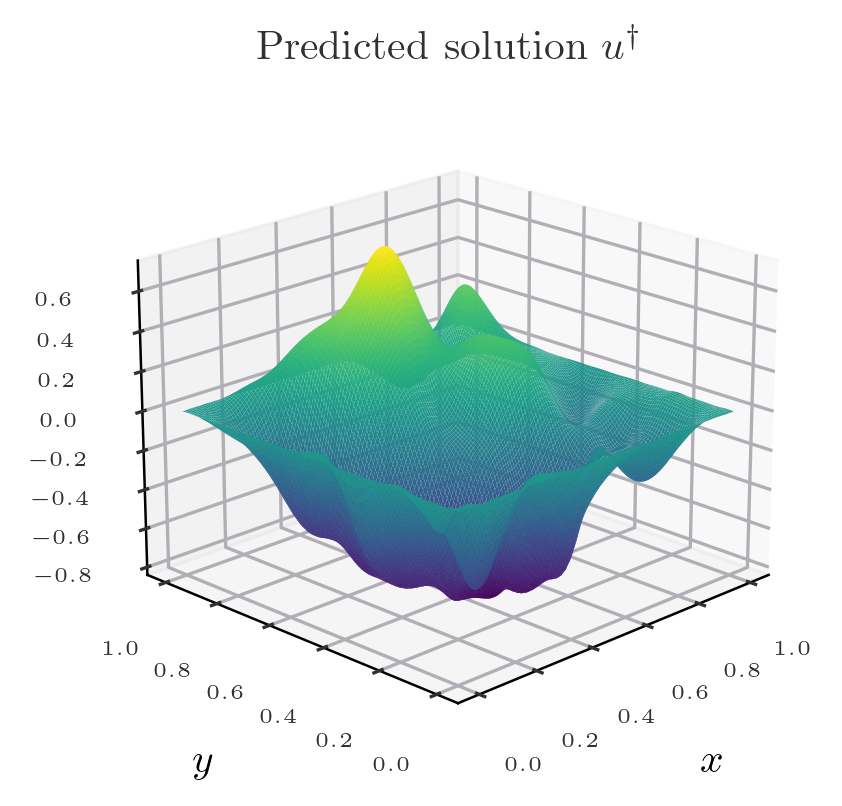

In [33]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, pred_grid,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"Predicted solution $u^\dagger$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

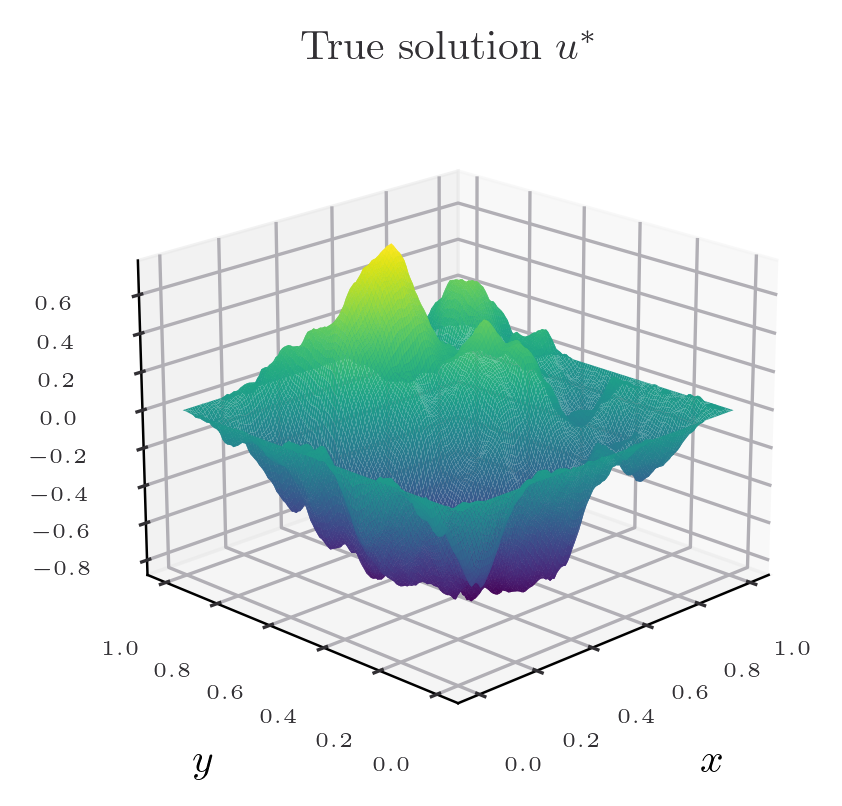

In [34]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, u_eval,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"True solution $u^*$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

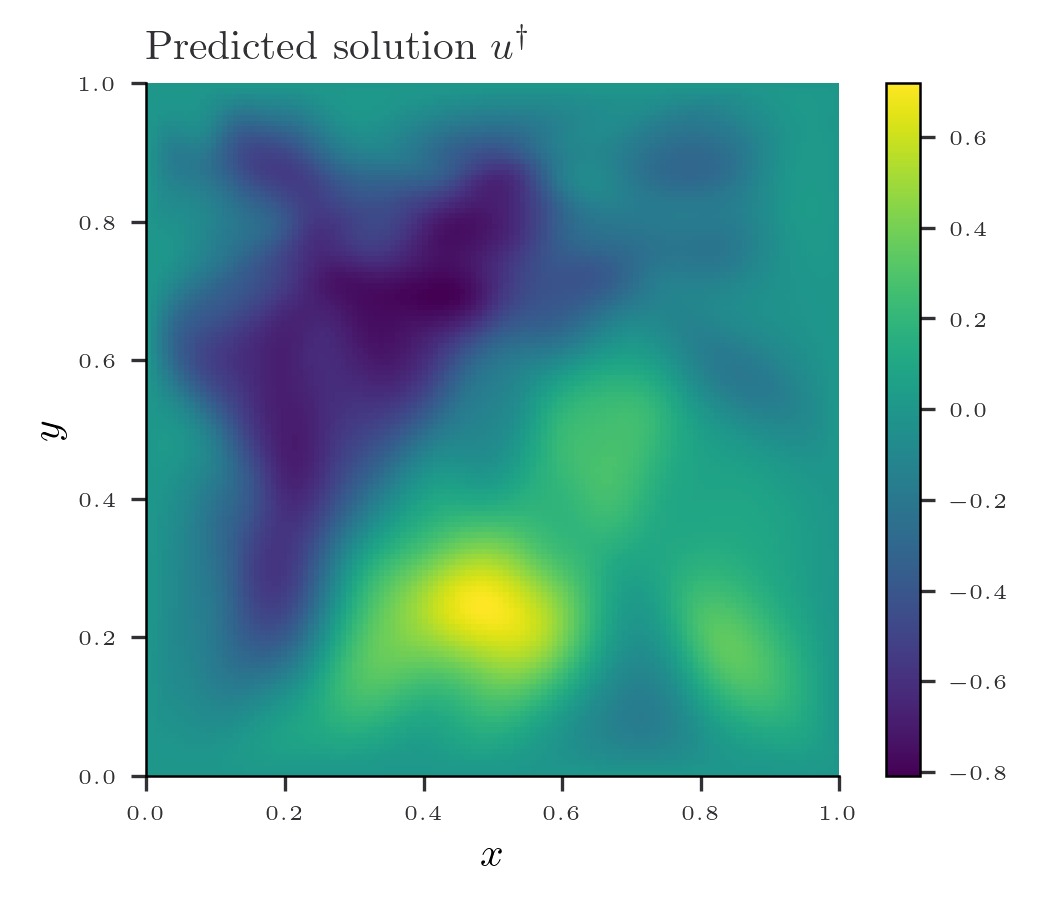

In [35]:
fig = plt.figure(figsize=(width, height))

plt.imshow(pred_grid, cmap='viridis', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Predicted solution $u^\dagger$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

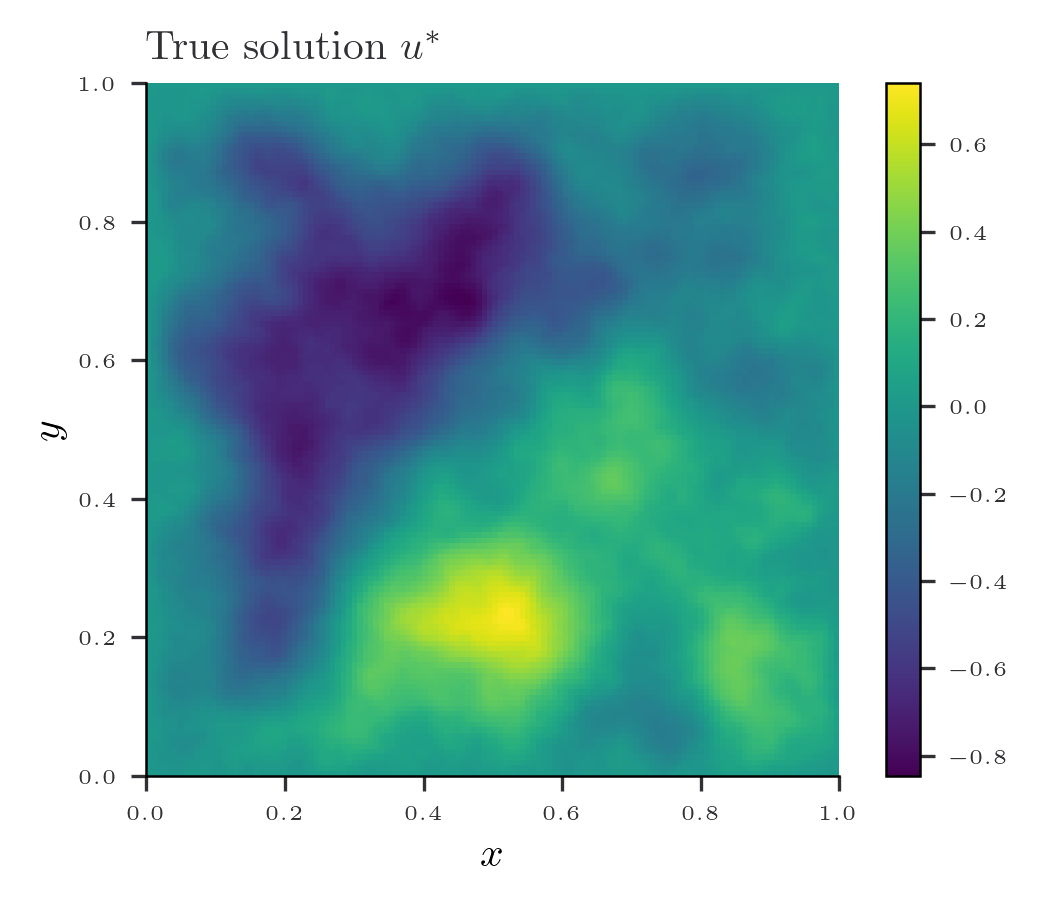

In [36]:
fig = plt.figure(figsize=(width, height))

plt.imshow(u_values, cmap='viridis', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'True solution $u^*$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

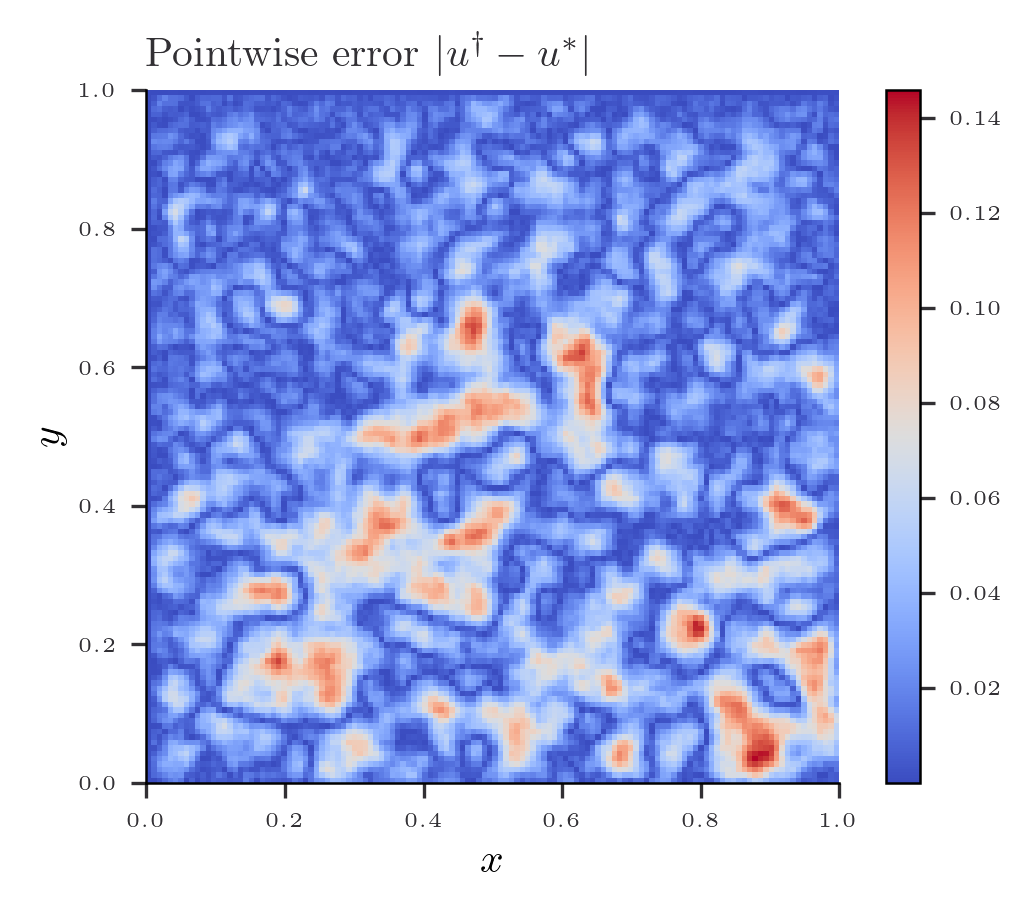

In [37]:
fig = plt.figure(figsize=(width, height))

plt.imshow(jnp.abs(pred_grid - u_values), cmap='coolwarm', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Pointwise error $|u^\dagger - u^*|$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

# Small PINN + shorter training

In [48]:
decay_nugget =  ((jnp.arange(0,n_points)[None]**2 + jnp.arange(0,n_points)[:,None]**2) + 1.0)**(-0.5)
decay_nugget

Array([[1.        , 0.70710678, 0.4472136 , ..., 0.01639124, 0.01612693,
        0.01587102],
       [0.70710678, 0.57735027, 0.40824829, ..., 0.01638904, 0.01612484,
        0.01586902],
       [0.4472136 , 0.40824829, 0.33333333, ..., 0.01638244, 0.01611855,
        0.01586303],
       ...,
       [0.01639124, 0.01638904, 0.01638244, ..., 0.01159114, 0.01149653,
        0.01140272],
       [0.01612693, 0.01612484, 0.01611855, ..., 0.01149653, 0.01140421,
        0.01131262],
       [0.01587102, 0.01586902, 0.01586303, ..., 0.01140272, 0.01131262,
        0.01122321]], dtype=float64, weak_type=True)

In [55]:
layer_sizes = [2,32,  32, 32, 32,  1]
key = random.PRNGKey(0)
params = init_params(layer_sizes, key)
print("There are {} parameters in the neural network.".format(count_parameters(params)))


neural_network = jit(vmap(predict, in_axes=(None, 0)))


def laplacian(params, x):
    return jnp.trace(hessian(predict, argnums=-1)(params, x))

nn_laplacian = jit(vmap(laplacian, in_axes = (None, 0)))


# Define the loss function
def loss_fn(params, grid, boundary, f, boundary_conditions, nu, n_points, w = 1.0):
    u_grid = neural_network(params, grid).reshape(n_points, n_points)
    non_linearity = tau(u_grid)
    laplacian_grid = nn_laplacian(params, grid).reshape(n_points, n_points)
    # Compute the sine transform
    pred_sine = dst_2d(-nu*laplacian_grid + non_linearity)
    residual_interior = (pred_sine - f)*decay_nugget

    pred_boundary = neural_network(params, boundary)
    residual_boundary = pred_boundary - boundary_conditions
    return w*jnp.mean(residual_interior**2) + jnp.mean(residual_boundary**2)

There are 3297 parameters in the neural network.


In [56]:
f_observed =  f_trans[:n_points,:n_points]

In [57]:
loss, grads = value_and_grad(loss_fn)(params, interior, boundary_points, f_observed, boundary_condition, nu, n_points, w = 1.0)
print(loss, grads)

0.9547650414480651 [(Array([[-0.00054782, -0.23647545, -0.20727723, -0.05298561, -0.15751018,
         0.11144192, -0.08643258,  0.04023369, -0.14903634, -0.0159398 ,
         0.07094623,  0.00525422, -0.38890466,  0.0839403 ,  0.03754477,
         0.07372078, -0.23450585,  0.07108816,  0.07579742, -0.29505166,
        -0.12484285, -0.09296064, -0.12679392, -0.00956789,  0.09190051,
         0.05222821, -0.09749686,  0.04304202, -0.04205929,  0.13224913,
         0.02575061, -0.05718077],
       [ 0.0261362 , -0.18413046, -0.32066921, -0.00879094, -0.10237314,
         0.11816198, -0.05344955,  0.17769726, -0.16531851, -0.06725785,
         0.13034726,  0.03579134, -0.48743141,  0.14223195,  0.03898453,
         0.16165787, -0.28301743,  0.06600583,  0.03083158, -0.51279097,
        -0.10041005, -0.12005118, -0.276353  ,  0.0467156 ,  0.08964582,
         0.06216575, -0.12826108,  0.08382568, -0.07899041,  0.07068593,
        -0.0895822 , -0.09973949]], dtype=float64), Array([ 0.025064

In [58]:
# Define the learning rate scheduler
initial_learning_rate = 1e-3
num_epochs = 1e5
decay_steps = num_epochs/10
decay_rate = 0.9

learning_rate_schedule = optax.exponential_decay(
    init_value=initial_learning_rate,
    transition_steps=decay_steps,
    decay_rate=decay_rate,
    transition_begin=0,
    staircase=False
)
optimizer = optax.adam(learning_rate_schedule)
opt_state = optimizer.init(params)

In [59]:
@jit
def train_step(params, opt_state):
    loss, grads = value_and_grad(loss_fn)(params, interior, boundary_points, f_observed, boundary_condition, nu, n_points)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss


In [60]:
patience = jnp.inf  # Number of epochs to wait for improvement
best_loss = float('inf')
epochs_without_improvement = 0

In [61]:
loss_hist = []
for epoch in range(int(num_epochs)):
    params, opt_state, loss = train_step(params, opt_state)
    if epoch % 1e4 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.7f}')
    loss_hist.append(loss)

    if epoch % decay_steps == 0:
        current_learning_rate = learning_rate_schedule(epoch)
        print(f'Step {epoch}, Training Loss: {loss:.7f}, Learning Rate: {current_learning_rate:.6f}')

    if loss < best_loss:
        best_loss = loss
        epochs_without_improvement = 0
        #best_param = params.copy()
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f'Early stopping at epoch {epoch}')
        break

Epoch 0, Loss: 0.9547650
Step 0, Training Loss: 0.9547650, Learning Rate: 0.001000
Epoch 10000, Loss: 0.0002330
Step 10000, Training Loss: 0.0002330, Learning Rate: 0.000900
Epoch 20000, Loss: 0.0001772
Step 20000, Training Loss: 0.0001772, Learning Rate: 0.000810
Epoch 30000, Loss: 0.0001457
Step 30000, Training Loss: 0.0001457, Learning Rate: 0.000729
Epoch 40000, Loss: 0.0001148
Step 40000, Training Loss: 0.0001148, Learning Rate: 0.000656
Epoch 50000, Loss: 0.0000908
Step 50000, Training Loss: 0.0000908, Learning Rate: 0.000590
Epoch 60000, Loss: 0.0000800
Step 60000, Training Loss: 0.0000800, Learning Rate: 0.000531
Epoch 70000, Loss: 0.0000704
Step 70000, Training Loss: 0.0000704, Learning Rate: 0.000478
Epoch 80000, Loss: 0.0000649
Step 80000, Training Loss: 0.0000649, Learning Rate: 0.000430
Epoch 90000, Loss: 0.0000609
Step 90000, Training Loss: 0.0000609, Learning Rate: 0.000387


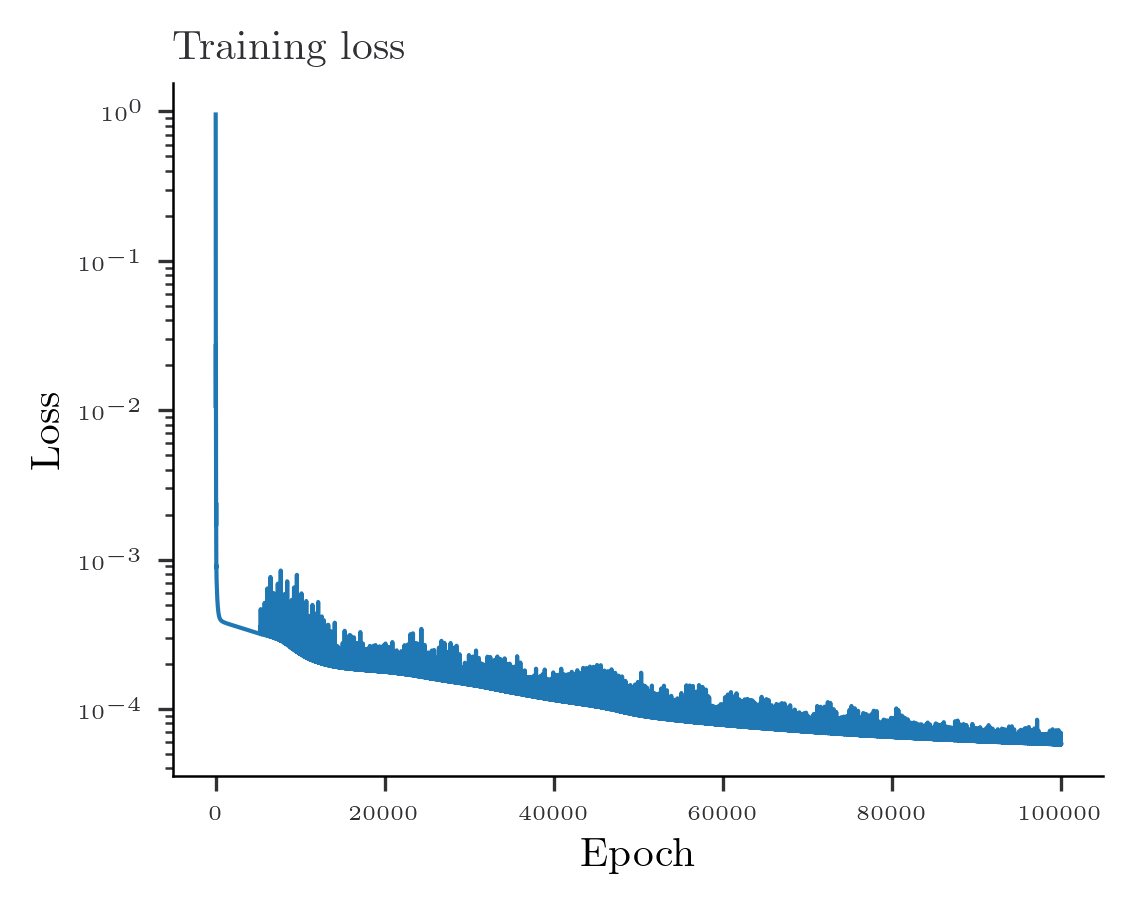

In [62]:
fig = plt.figure(figsize=(width, height))
plt.plot(loss_hist)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

In [63]:
n_eval = n_coef
x_eval = jnp.linspace(lower, upper, n_eval)
y_eval = jnp.linspace(lower, upper, n_eval)
X, Y = jnp.meshgrid(x_eval, y_eval)
interior_eval = create_interior(x_eval, y_eval)
u_eval =evaluate_basis_sine_2d(x_eval,y_eval, coef_u)

In [64]:
pred_grid = neural_network(params, interior_eval).reshape(n_eval, n_eval)

In [65]:
print(compute_2d_error(pred_grid, u_eval, x_eval, y_eval))

(Array(0.02803998, dtype=float64), Array(0.08632536, dtype=float64))


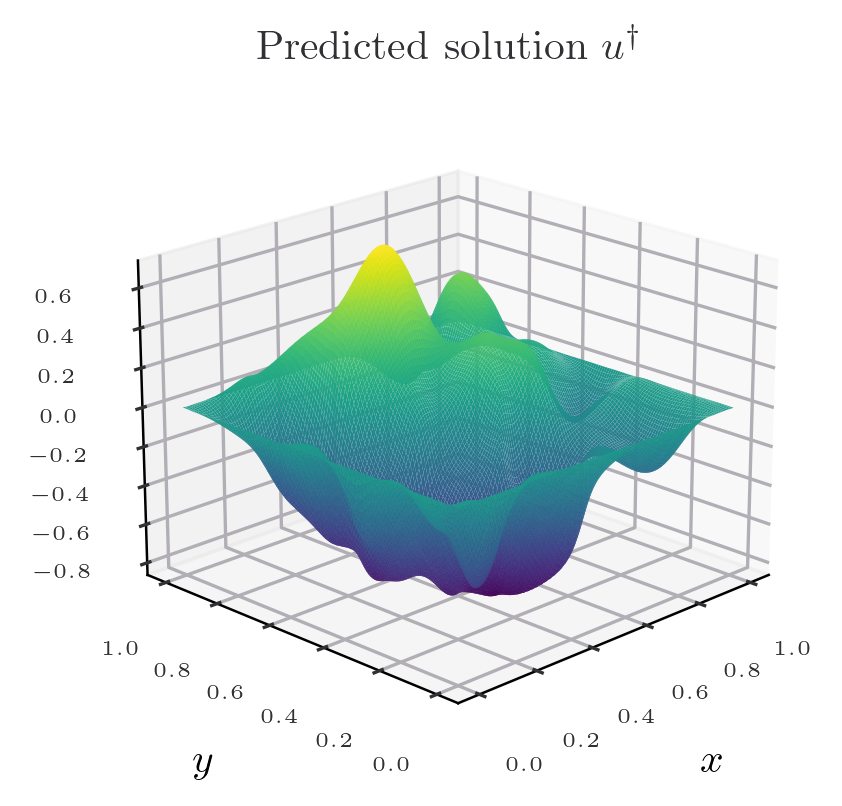

In [66]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, pred_grid,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"Predicted solution $u^\dagger$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

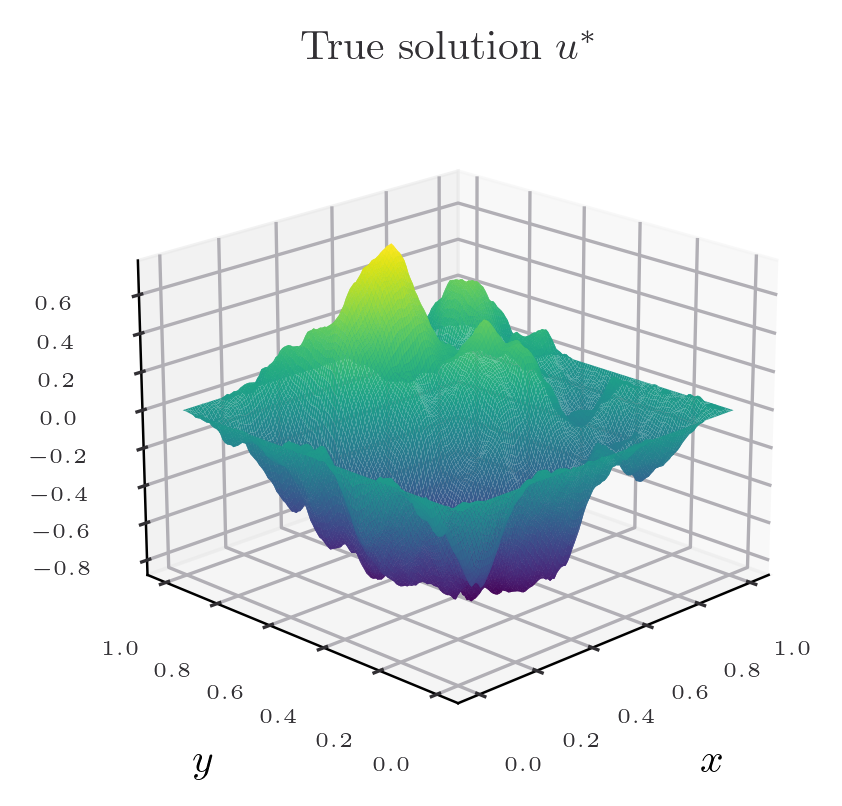

In [67]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, u_eval,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"True solution $u^*$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

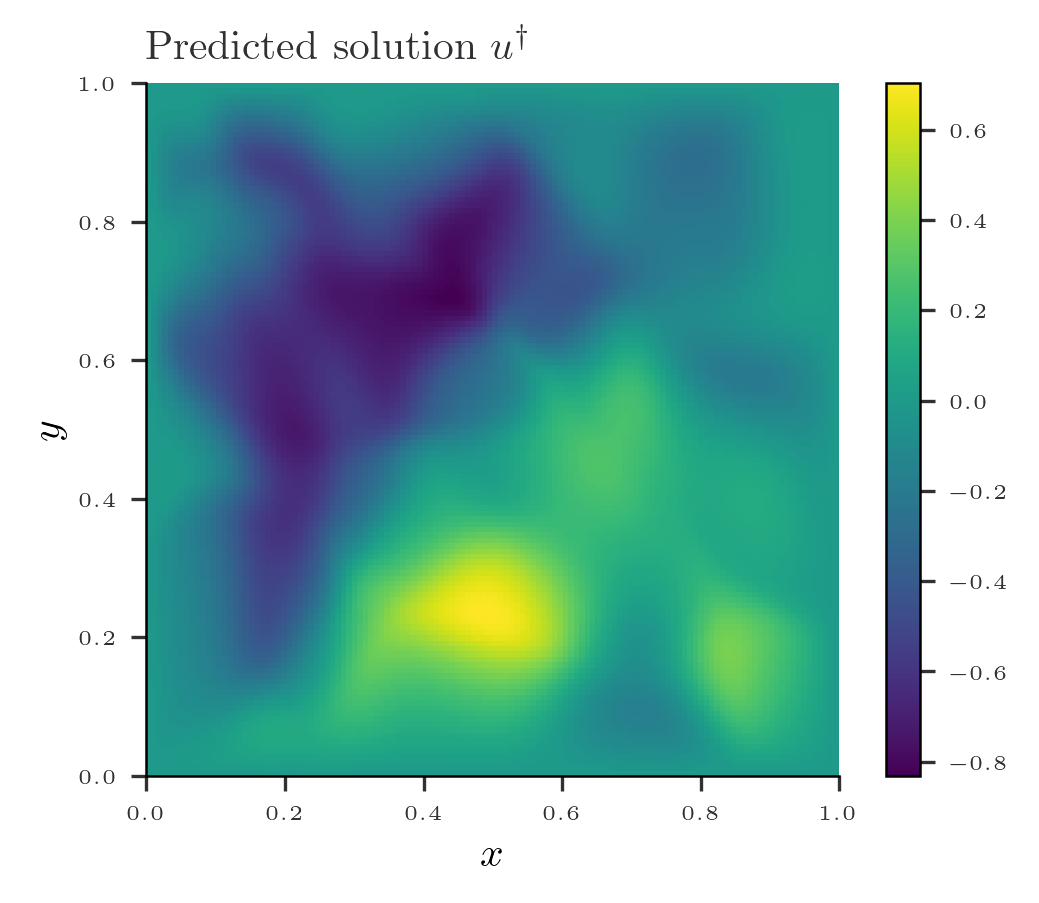

In [68]:
fig = plt.figure(figsize=(width, height))

plt.imshow(pred_grid, cmap='viridis', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Predicted solution $u^\dagger$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

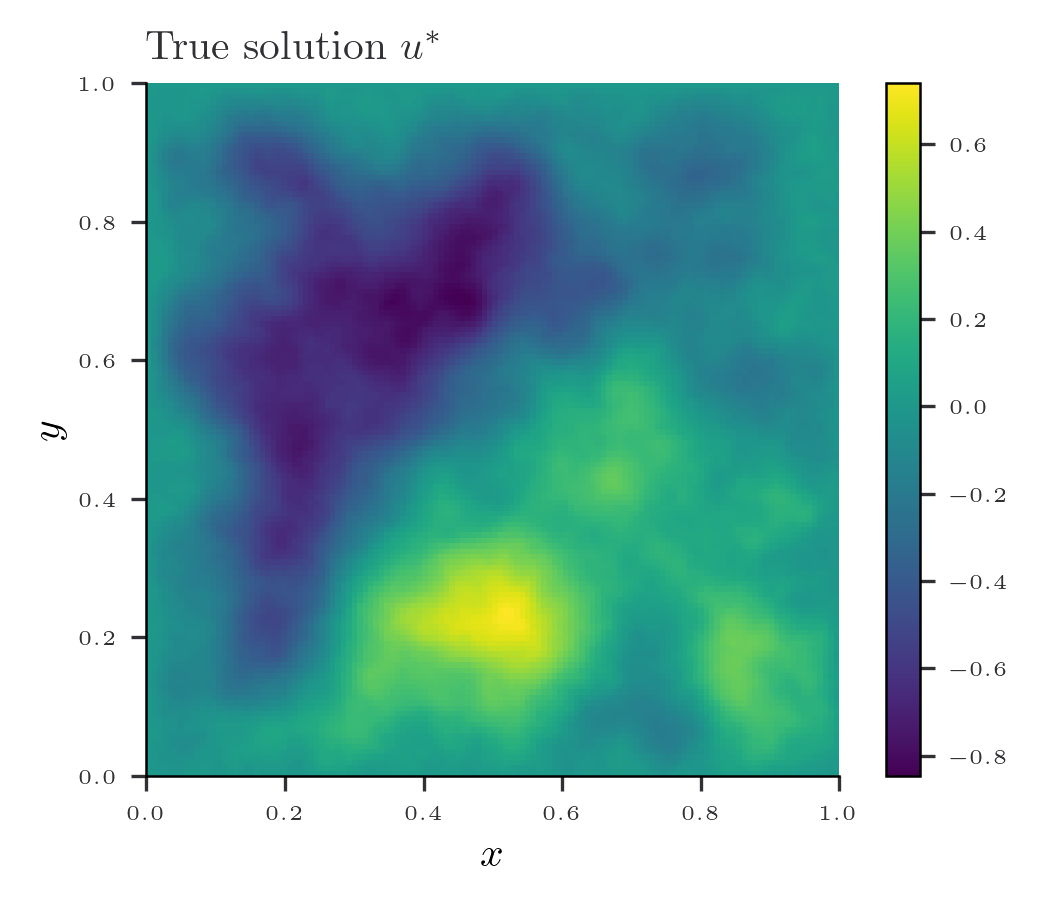

In [69]:
fig = plt.figure(figsize=(width, height))

plt.imshow(u_values, cmap='viridis', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'True solution $u^*$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

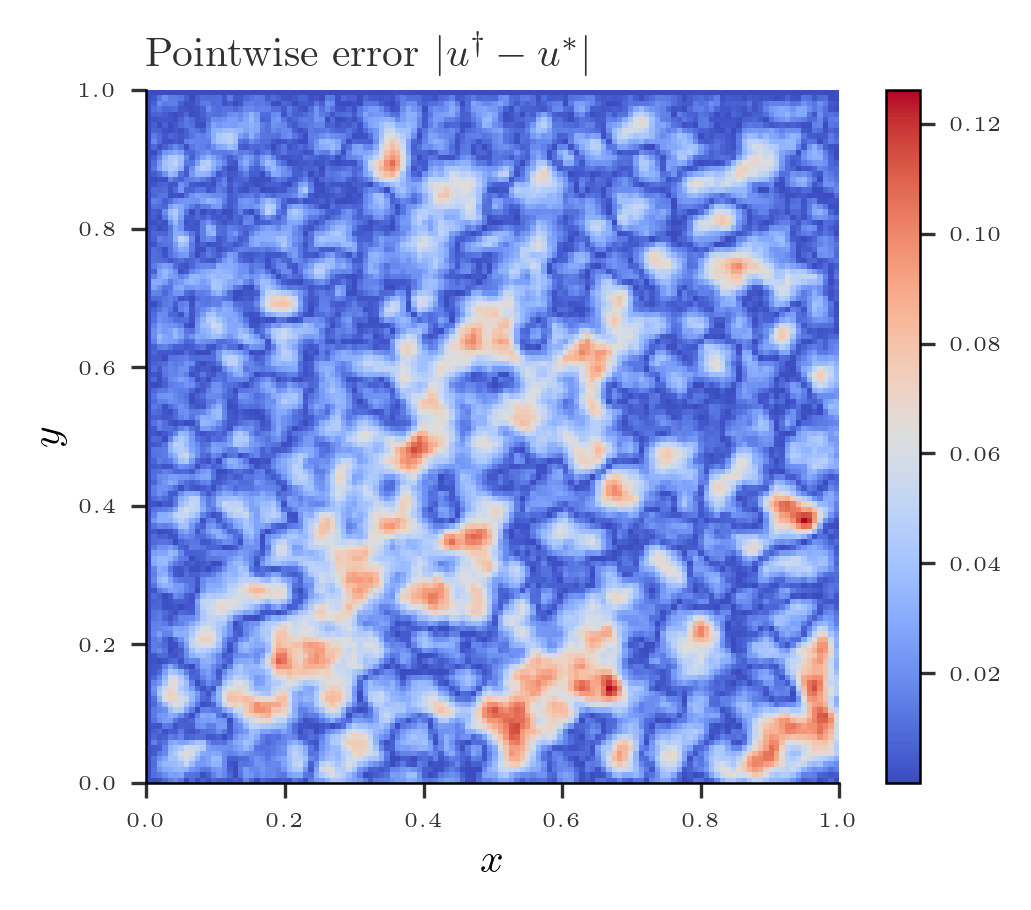

In [70]:
fig = plt.figure(figsize=(width, height))

plt.imshow(jnp.abs(pred_grid - u_values), cmap='coolwarm', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Pointwise error $|u^\dagger - u^*|$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

# Overparametrized PINN + shorter training

In [71]:
decay_nugget =  ((jnp.arange(0,n_points)[None]**2 + jnp.arange(0,n_points)[:,None]**2) + 1.0)**(-0.5)
decay_nugget

Array([[1.        , 0.70710678, 0.4472136 , ..., 0.01639124, 0.01612693,
        0.01587102],
       [0.70710678, 0.57735027, 0.40824829, ..., 0.01638904, 0.01612484,
        0.01586902],
       [0.4472136 , 0.40824829, 0.33333333, ..., 0.01638244, 0.01611855,
        0.01586303],
       ...,
       [0.01639124, 0.01638904, 0.01638244, ..., 0.01159114, 0.01149653,
        0.01140272],
       [0.01612693, 0.01612484, 0.01611855, ..., 0.01149653, 0.01140421,
        0.01131262],
       [0.01587102, 0.01586902, 0.01586303, ..., 0.01140272, 0.01131262,
        0.01122321]], dtype=float64, weak_type=True)

In [75]:
layer_sizes = [2,64,  64, 64, 64, 1]
key = random.PRNGKey(0)
params = init_params(layer_sizes, key)
print("There are {} parameters in the neural network.".format(count_parameters(params)))


neural_network = jit(vmap(predict, in_axes=(None, 0)))


def laplacian(params, x):
    return jnp.trace(hessian(predict, argnums=-1)(params, x))

nn_laplacian = jit(vmap(laplacian, in_axes = (None, 0)))


# Define the loss function
def loss_fn(params, grid, boundary, f, boundary_conditions, nu, n_points, w = 1.0):
    u_grid = neural_network(params, grid).reshape(n_points, n_points)
    non_linearity = tau(u_grid)
    laplacian_grid = nn_laplacian(params, grid).reshape(n_points, n_points)
    # Compute the sine transform
    pred_sine = dst_2d(-nu*laplacian_grid + non_linearity)
    residual_interior = (pred_sine - f)*decay_nugget

    pred_boundary = neural_network(params, boundary)
    residual_boundary = pred_boundary - boundary_conditions
    return w*jnp.mean(residual_interior**2) + jnp.mean(residual_boundary**2)

There are 12737 parameters in the neural network.


In [76]:
f_observed =  f_trans[:n_points,:n_points]

In [77]:
loss, grads = value_and_grad(loss_fn)(params, interior, boundary_points, f_observed, boundary_condition, nu, n_points, w = 1.0)
print(loss, grads)

1.8925653778925595 [(Array([[ 0.01876768,  0.00635374,  0.01339388,  0.00944808,  0.22723799,
         0.02474735, -0.15100755, -0.02031319, -0.02108541,  0.13013158,
         0.03554963, -0.02088759,  0.04583386, -0.13333531,  0.11069067,
        -0.07556355, -0.06689366,  0.03654734, -0.07311437, -0.03435706,
         0.01247517,  0.29916794, -0.00309967, -0.03577418, -0.07870194,
        -0.15842999,  0.07970056,  0.03761865, -0.07491405,  0.11589181,
         0.1341306 ,  0.07522936, -0.00618673, -0.1266781 ,  0.19959733,
         0.1139234 , -0.01934689, -0.0832605 , -0.12104297, -0.10588844,
        -0.0371085 , -0.02881803, -0.08297495, -0.11761888, -0.03185308,
        -0.0135322 , -0.03919642,  0.03245934, -0.0092972 ,  0.11119078,
        -0.01206194,  0.0406045 ,  0.00913465,  0.08878064, -0.1125918 ,
         0.02779305,  0.02146181,  0.02527112, -0.04882608,  0.03944065,
        -0.03375728,  0.04474409, -0.16621289, -0.01746674],
       [ 0.01231304,  0.02104339,  0.04619

In [78]:
# Define the learning rate scheduler
initial_learning_rate = 1e-3
num_epochs = 1e5
decay_steps = num_epochs/10
decay_rate = 0.9

learning_rate_schedule = optax.exponential_decay(
    init_value=initial_learning_rate,
    transition_steps=decay_steps,
    decay_rate=decay_rate,
    transition_begin=0,
    staircase=False
)
optimizer = optax.adam(learning_rate_schedule)
opt_state = optimizer.init(params)

In [79]:
@jit
def train_step(params, opt_state):
    loss, grads = value_and_grad(loss_fn)(params, interior, boundary_points, f_observed, boundary_condition, nu, n_points)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss


In [80]:
patience = jnp.inf  # Number of epochs to wait for improvement
best_loss = float('inf')
epochs_without_improvement = 0

In [81]:
loss_hist = []
for epoch in range(int(num_epochs)):
    params, opt_state, loss = train_step(params, opt_state)
    if epoch % 1e4 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.7f}')
    loss_hist.append(loss)

    if epoch % decay_steps == 0:
        current_learning_rate = learning_rate_schedule(epoch)
        print(f'Step {epoch}, Training Loss: {loss:.7f}, Learning Rate: {current_learning_rate:.6f}')

    if loss < best_loss:
        best_loss = loss
        epochs_without_improvement = 0
        #best_param = params.copy()
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f'Early stopping at epoch {epoch}')
        break

Epoch 0, Loss: 1.8925654
Step 0, Training Loss: 1.8925654, Learning Rate: 0.001000
Epoch 10000, Loss: 0.0002074
Step 10000, Training Loss: 0.0002074, Learning Rate: 0.000900
Epoch 20000, Loss: 0.0001577
Step 20000, Training Loss: 0.0001577, Learning Rate: 0.000810
Epoch 30000, Loss: 0.0000964
Step 30000, Training Loss: 0.0000964, Learning Rate: 0.000729
Epoch 40000, Loss: 0.0000695
Step 40000, Training Loss: 0.0000695, Learning Rate: 0.000656
Epoch 50000, Loss: 0.0000585
Step 50000, Training Loss: 0.0000585, Learning Rate: 0.000590
Epoch 60000, Loss: 0.0000508
Step 60000, Training Loss: 0.0000508, Learning Rate: 0.000531
Epoch 70000, Loss: 0.0000500
Step 70000, Training Loss: 0.0000500, Learning Rate: 0.000478
Epoch 80000, Loss: 0.0000409
Step 80000, Training Loss: 0.0000409, Learning Rate: 0.000430
Epoch 90000, Loss: 0.0000417
Step 90000, Training Loss: 0.0000417, Learning Rate: 0.000387


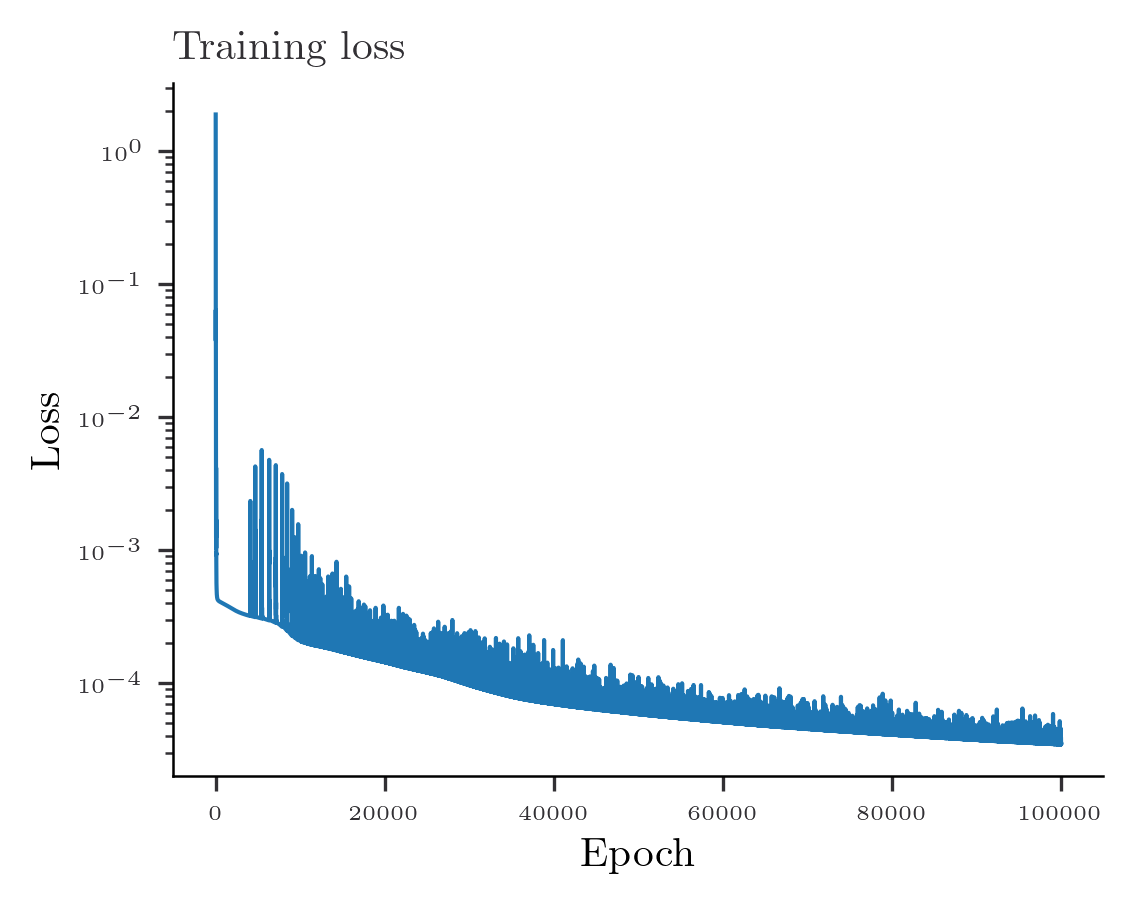

In [82]:
fig = plt.figure(figsize=(width, height))
plt.plot(loss_hist)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

In [83]:
n_eval = n_coef
x_eval = jnp.linspace(lower, upper, n_eval)
y_eval = jnp.linspace(lower, upper, n_eval)
X, Y = jnp.meshgrid(x_eval, y_eval)
interior_eval = create_interior(x_eval, y_eval)
u_eval =evaluate_basis_sine_2d(x_eval,y_eval, coef_u)

In [84]:
pred_grid = neural_network(params, interior_eval).reshape(n_eval, n_eval)

In [85]:
print(compute_2d_error(pred_grid, u_eval, x_eval, y_eval))

(Array(0.02086188, dtype=float64), Array(0.06422648, dtype=float64))


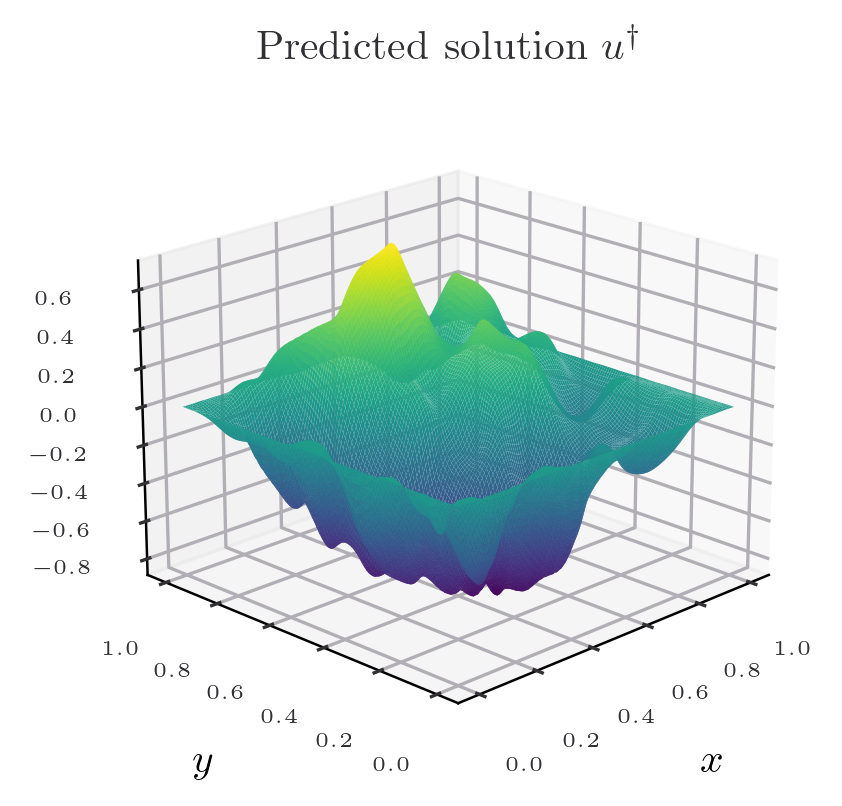

In [86]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, pred_grid,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"Predicted solution $u^\dagger$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

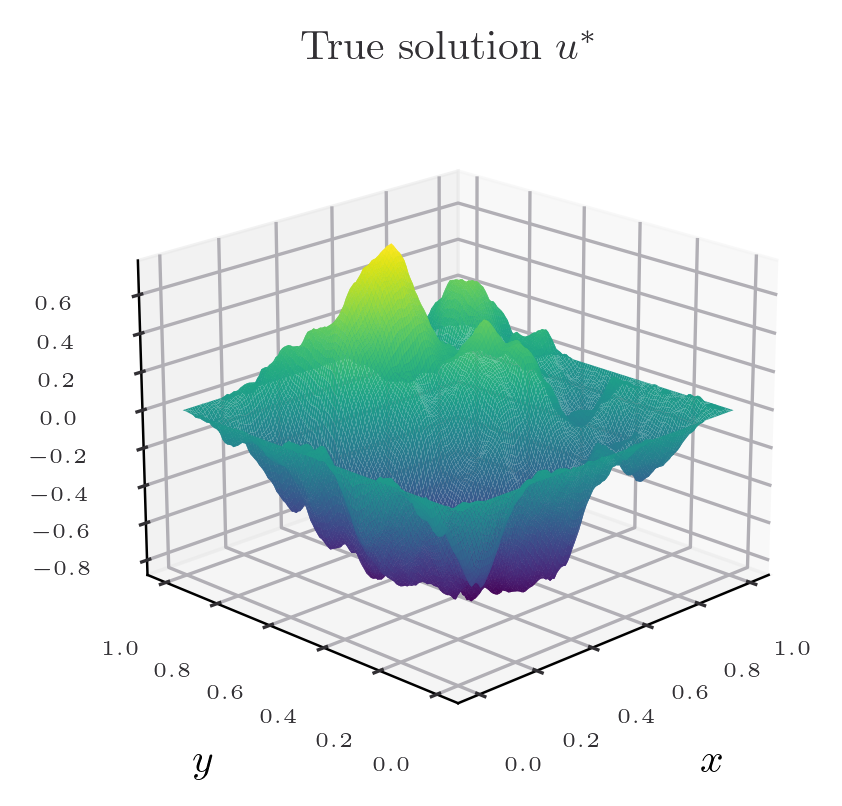

In [87]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, u_eval,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"True solution $u^*$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

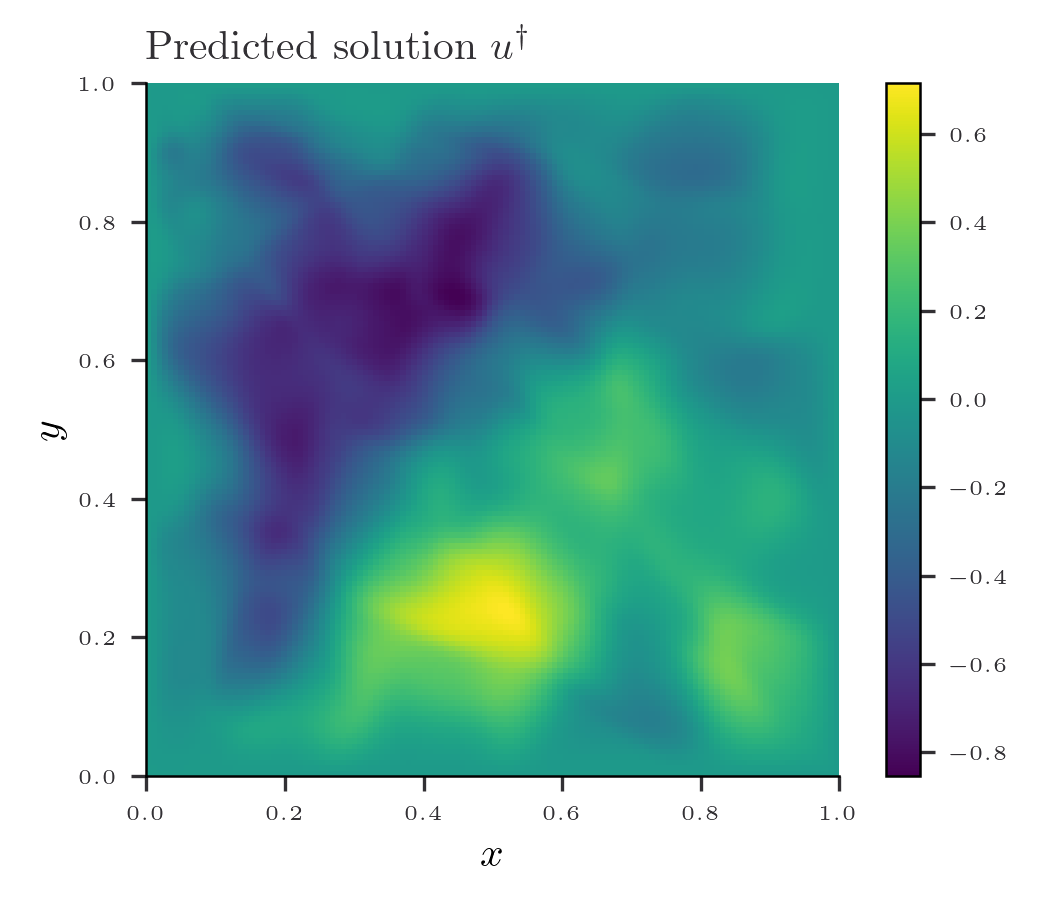

In [88]:
fig = plt.figure(figsize=(width, height))

plt.imshow(pred_grid, cmap='viridis', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Predicted solution $u^\dagger$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

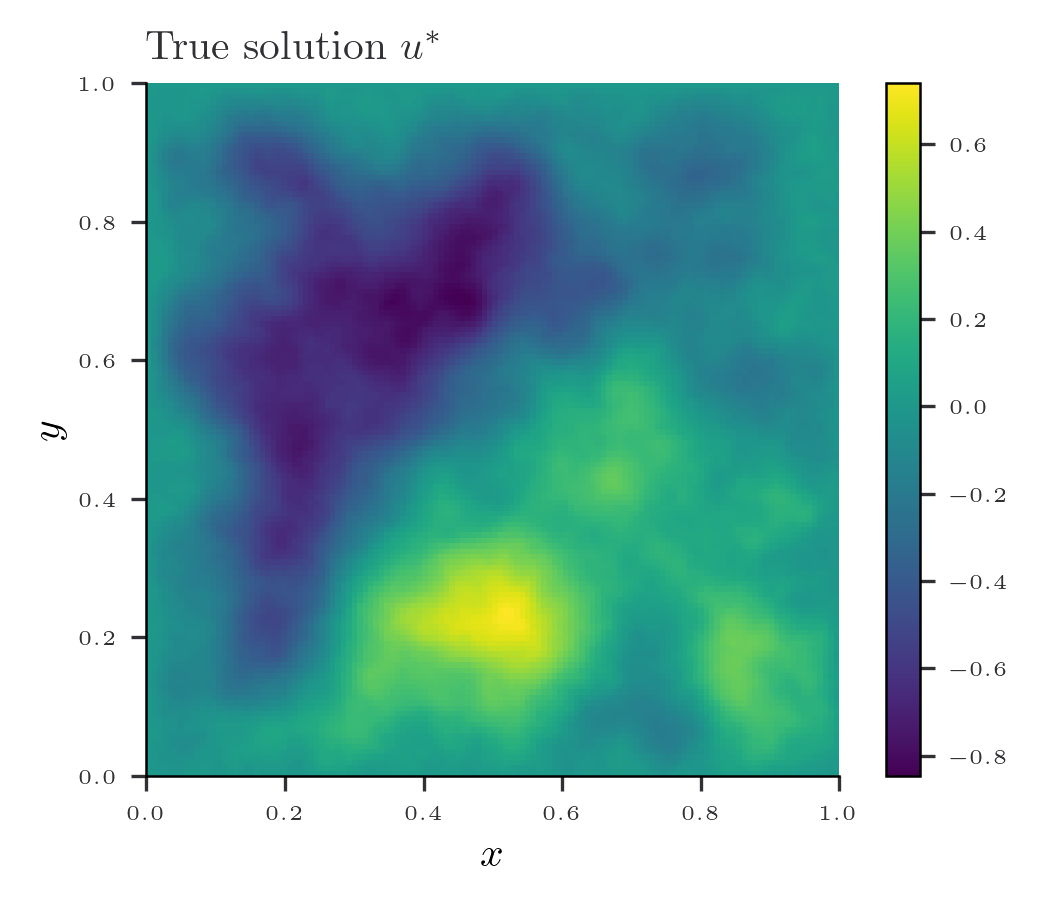

In [89]:
fig = plt.figure(figsize=(width, height))

plt.imshow(u_values, cmap='viridis', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'True solution $u^*$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

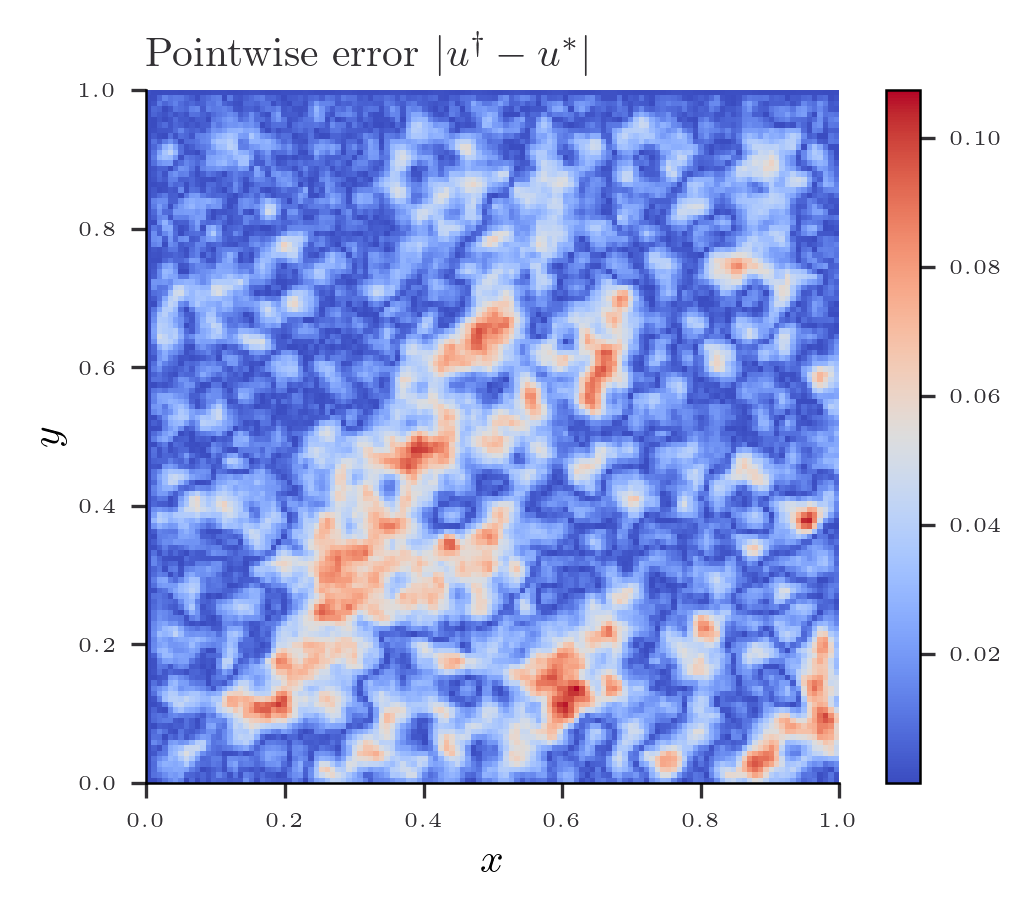

In [90]:
fig = plt.figure(figsize=(width, height))

plt.imshow(jnp.abs(pred_grid - u_values), cmap='coolwarm', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Pointwise error $|u^\dagger - u^*|$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

# PINN solution: Glorot normal initialization

In [107]:
decay_nugget =  ((jnp.arange(0,n_points)[None]**2 + jnp.arange(0,n_points)[:,None]**2) + 1.0)**(-0.5)
decay_nugget

Array([[1.        , 0.70710678, 0.4472136 , ..., 0.01639124, 0.01612693,
        0.01587102],
       [0.70710678, 0.57735027, 0.40824829, ..., 0.01638904, 0.01612484,
        0.01586902],
       [0.4472136 , 0.40824829, 0.33333333, ..., 0.01638244, 0.01611855,
        0.01586303],
       ...,
       [0.01639124, 0.01638904, 0.01638244, ..., 0.01159114, 0.01149653,
        0.01140272],
       [0.01612693, 0.01612484, 0.01611855, ..., 0.01149653, 0.01140421,
        0.01131262],
       [0.01587102, 0.01586902, 0.01586303, ..., 0.01140272, 0.01131262,
        0.01122321]], dtype=float64, weak_type=True)

In [108]:
layer_sizes = [2, 64, 64,  1]
key = random.PRNGKey(0)
params = init_glorot_normal_params(layer_sizes, key)#init_params(layer_sizes, key)
print("There are {} parameters in the neural network.".format(count_parameters(params)))


neural_network = jit(vmap(predict, in_axes=(None, 0)))


def laplacian(params, x):
    return jnp.trace(hessian(predict, argnums=-1)(params, x))

nn_laplacian = jit(vmap(laplacian, in_axes = (None, 0)))


# Define the loss function
def loss_fn(params, grid, boundary, f, boundary_conditions, nu, n_points, w = 1.0):
    u_grid = neural_network(params, grid).reshape(n_points, n_points)
    non_linearity = tau(u_grid)
    laplacian_grid = nn_laplacian(params, grid).reshape(n_points, n_points)
    # Compute the sine transform
    pred_sine = dst_2d(-nu*laplacian_grid + non_linearity)
    residual_interior = (pred_sine - f)*decay_nugget

    pred_boundary = neural_network(params, boundary)
    residual_boundary = pred_boundary - boundary_conditions
    return w*jnp.mean(residual_interior**2) + jnp.mean(residual_boundary**2)

There are 4417 parameters in the neural network.


In [109]:
f_observed =  f_trans[:n_points,:n_points]

In [110]:
loss, grads = value_and_grad(loss_fn)(params, interior, boundary_points, f_observed, boundary_condition, nu, n_points, w = 1.0)
print(loss, grads)

0.004004293717537304 [(Array([[ 1.73974501e-03, -5.57639487e-04, -9.84496632e-03,
        -7.50951397e-03, -1.62459839e-02, -5.94040556e-03,
         1.17679453e-02, -5.60645072e-03, -1.20657544e-03,
         8.19106302e-03, -1.84059205e-03, -8.35950864e-04,
        -1.09282651e-02,  4.36176623e-04, -7.45989688e-05,
        -6.34723803e-03, -1.31175620e-02, -1.09287220e-02,
         1.41139167e-02,  2.42028558e-04,  1.08568048e-02,
         8.18867176e-03,  1.40731382e-03,  9.43836147e-03,
         3.14260883e-03, -5.59368260e-03, -7.67204231e-03,
        -2.76128947e-03,  1.41041313e-03, -6.61474521e-03,
        -2.95137860e-03,  5.48091511e-04, -4.65283715e-03,
        -6.18340526e-03,  3.16034962e-03, -8.83169518e-03,
         5.87868641e-03,  1.01615890e-02,  7.72345782e-03,
        -4.34985893e-03,  3.46587479e-03, -5.41537983e-03,
        -1.02796883e-02, -5.24930203e-03, -4.77989093e-03,
         4.01537852e-03,  7.50617933e-03, -6.44990206e-03,
        -4.15431566e-03, -4.19483

In [111]:
# Define the learning rate scheduler
initial_learning_rate = 1e-3
num_epochs = 3e5
decay_steps = num_epochs/10
decay_rate = 0.9

learning_rate_schedule = optax.exponential_decay(
    init_value=initial_learning_rate,
    transition_steps=decay_steps,
    decay_rate=decay_rate,
    transition_begin=0,
    staircase=False
)
optimizer = optax.adam(learning_rate_schedule)
opt_state = optimizer.init(params)

In [112]:
decay_steps, num_epochs

(30000.0, 300000.0)

In [113]:
@jit
def train_step(params, opt_state):
    loss, grads = value_and_grad(loss_fn)(params, interior, boundary_points, f_observed, boundary_condition, nu, n_points)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss


In [114]:
patience = jnp.inf  # Number of epochs to wait for improvement
best_loss = float('inf')
epochs_without_improvement = 0

In [115]:
loss_hist = []
for epoch in range(int(num_epochs)):
    params, opt_state, loss = train_step(params, opt_state)
    if epoch % 1e4 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.7f}')
    loss_hist.append(loss)

    if epoch % decay_steps == 0:
        current_learning_rate = learning_rate_schedule(epoch)
        print(f'Step {epoch}, Training Loss: {loss:.4f}, Learning Rate: {current_learning_rate:.6f}')

    if loss < best_loss:
        best_loss = loss
        epochs_without_improvement = 0
        #best_param = params.copy()
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f'Early stopping at epoch {epoch}')
        break

Epoch 0, Loss: 0.0040043
Step 0, Training Loss: 0.0040, Learning Rate: 0.001000
Epoch 10000, Loss: 0.0003920
Epoch 20000, Loss: 0.0003902
Epoch 30000, Loss: 0.0003249
Step 30000, Training Loss: 0.0003, Learning Rate: 0.000900
Epoch 40000, Loss: 0.0003022
Epoch 50000, Loss: 0.0002074
Epoch 60000, Loss: 0.0002037
Step 60000, Training Loss: 0.0002, Learning Rate: 0.000810
Epoch 70000, Loss: 0.0001891
Epoch 80000, Loss: 0.0001835
Epoch 90000, Loss: 0.0001723
Step 90000, Training Loss: 0.0002, Learning Rate: 0.000729
Epoch 100000, Loss: 0.0001656
Epoch 110000, Loss: 0.0001602
Epoch 120000, Loss: 0.0001573
Step 120000, Training Loss: 0.0002, Learning Rate: 0.000656
Epoch 130000, Loss: 0.0001484
Epoch 140000, Loss: 0.0001418
Epoch 150000, Loss: 0.0001351
Step 150000, Training Loss: 0.0001, Learning Rate: 0.000590
Epoch 160000, Loss: 0.0001253
Epoch 170000, Loss: 0.0001267
Epoch 180000, Loss: 0.0001187
Step 180000, Training Loss: 0.0001, Learning Rate: 0.000531
Epoch 190000, Loss: 0.0001153
Ep

In [ ]:
0.0000533

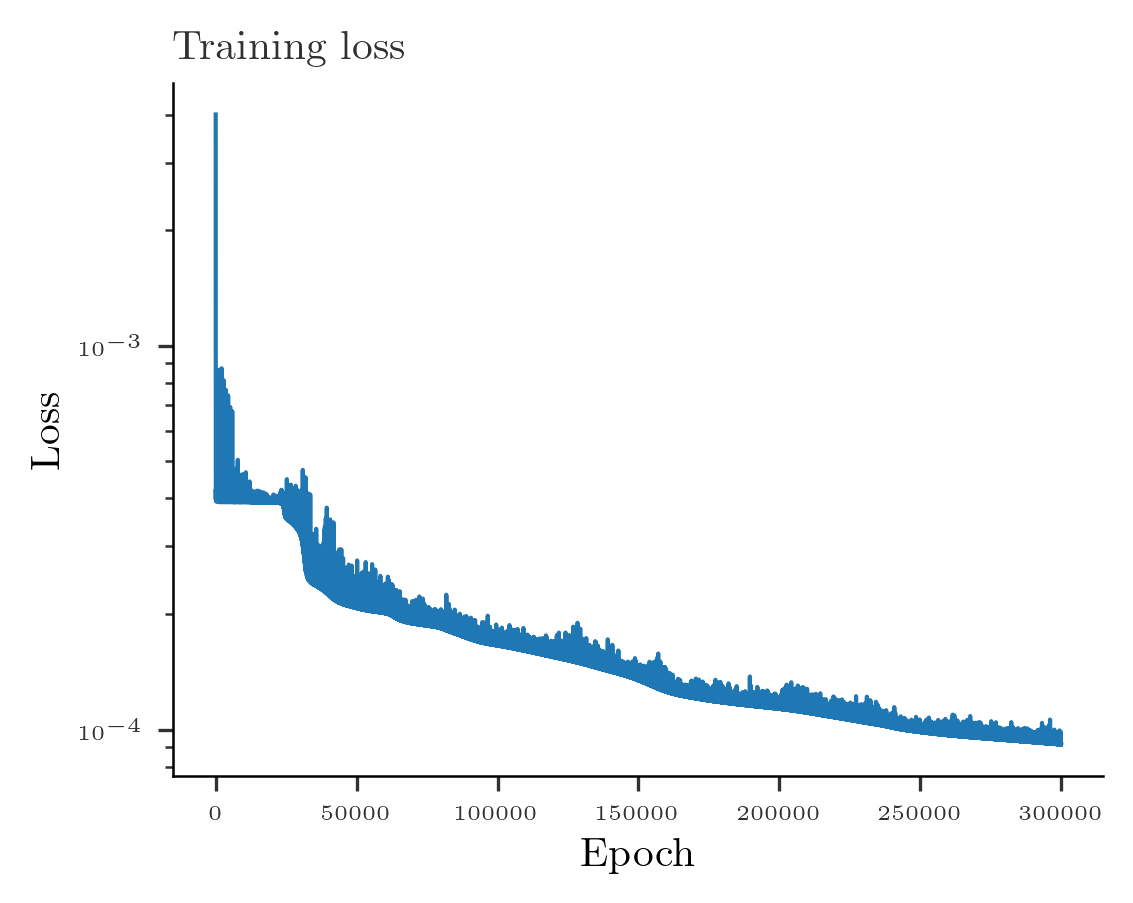

In [116]:
fig = plt.figure(figsize=(width, height))
plt.plot(loss_hist)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

In [117]:
n_eval = n_coef
x_eval = jnp.linspace(lower, upper, n_eval)
y_eval = jnp.linspace(lower, upper, n_eval)
X, Y = jnp.meshgrid(x_eval, y_eval)
interior_eval = create_interior(x_eval, y_eval)
u_eval =evaluate_basis_sine_2d(x_eval,y_eval, coef_u)

In [118]:
pred_grid = neural_network(params, interior_eval).reshape(n_eval, n_eval)

In [119]:
print(compute_2d_error(pred_grid, u_eval, x_eval, y_eval))

(Array(0.0414746, dtype=float64), Array(0.1276859, dtype=float64))


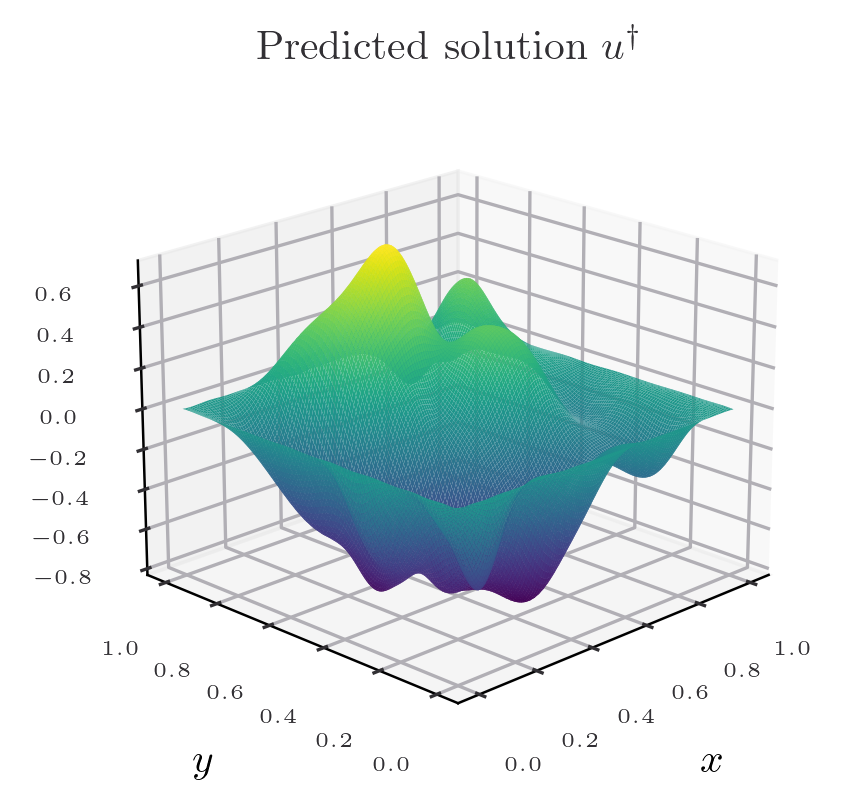

In [120]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, pred_grid,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"Predicted solution $u^\dagger$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

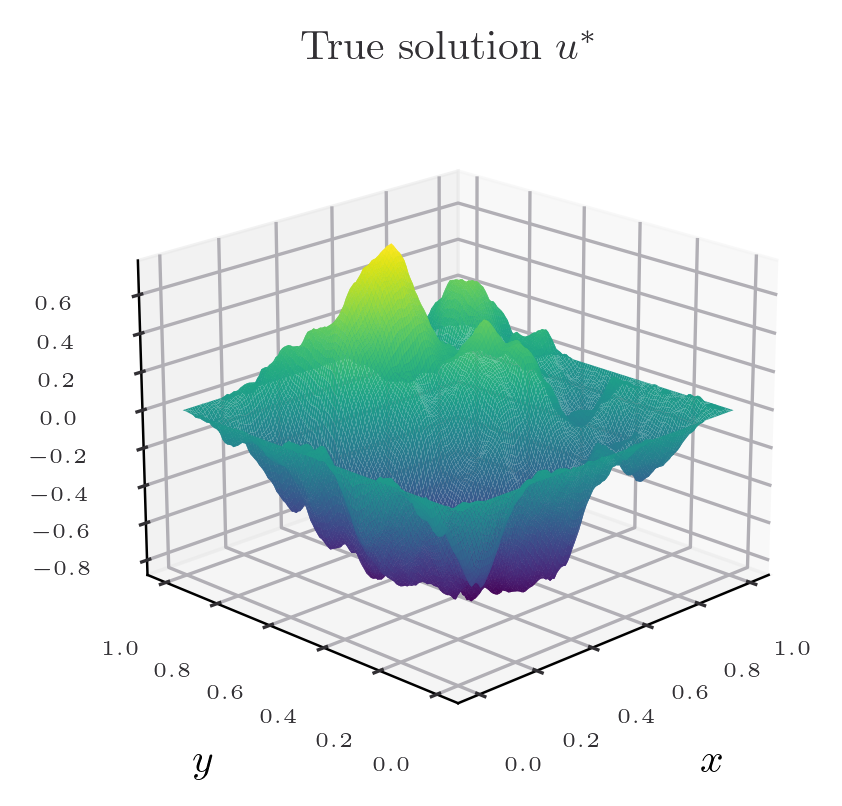

In [121]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, u_eval,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"True solution $u^*$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

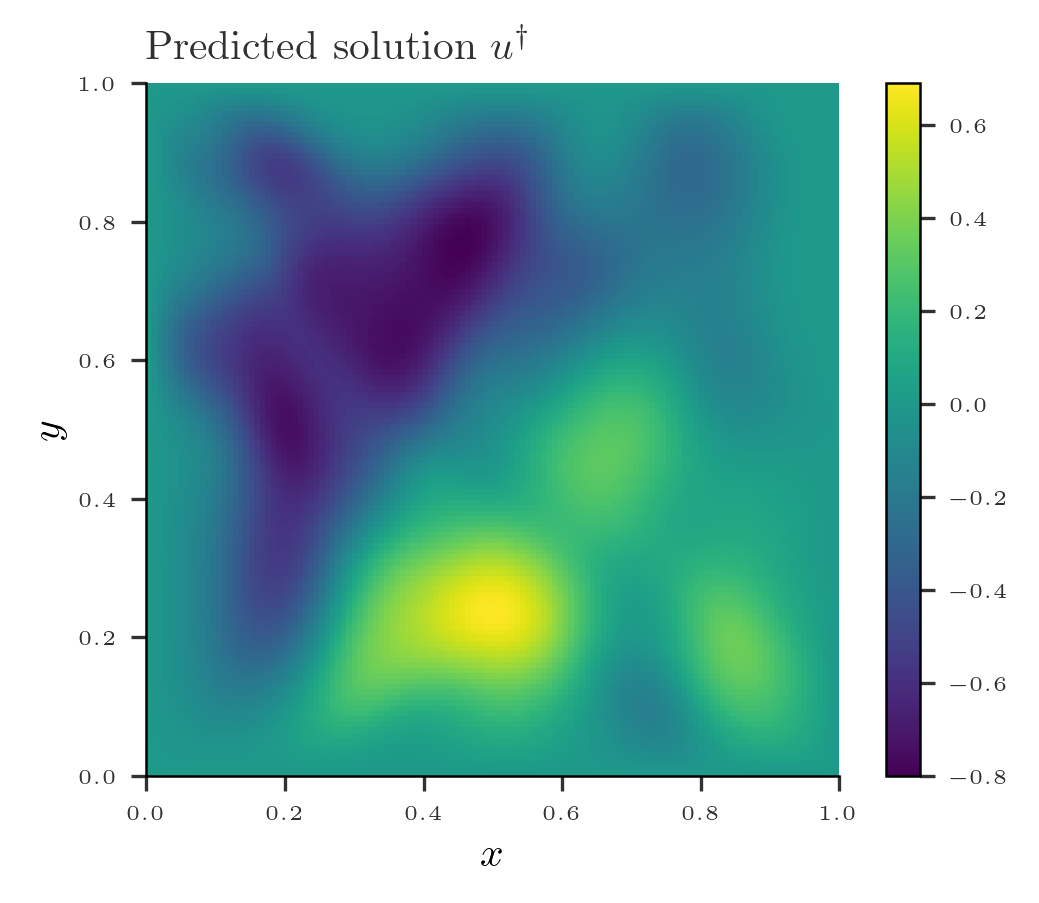

In [122]:
fig = plt.figure(figsize=(width, height))

plt.imshow(pred_grid, cmap='viridis', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Predicted solution $u^\dagger$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

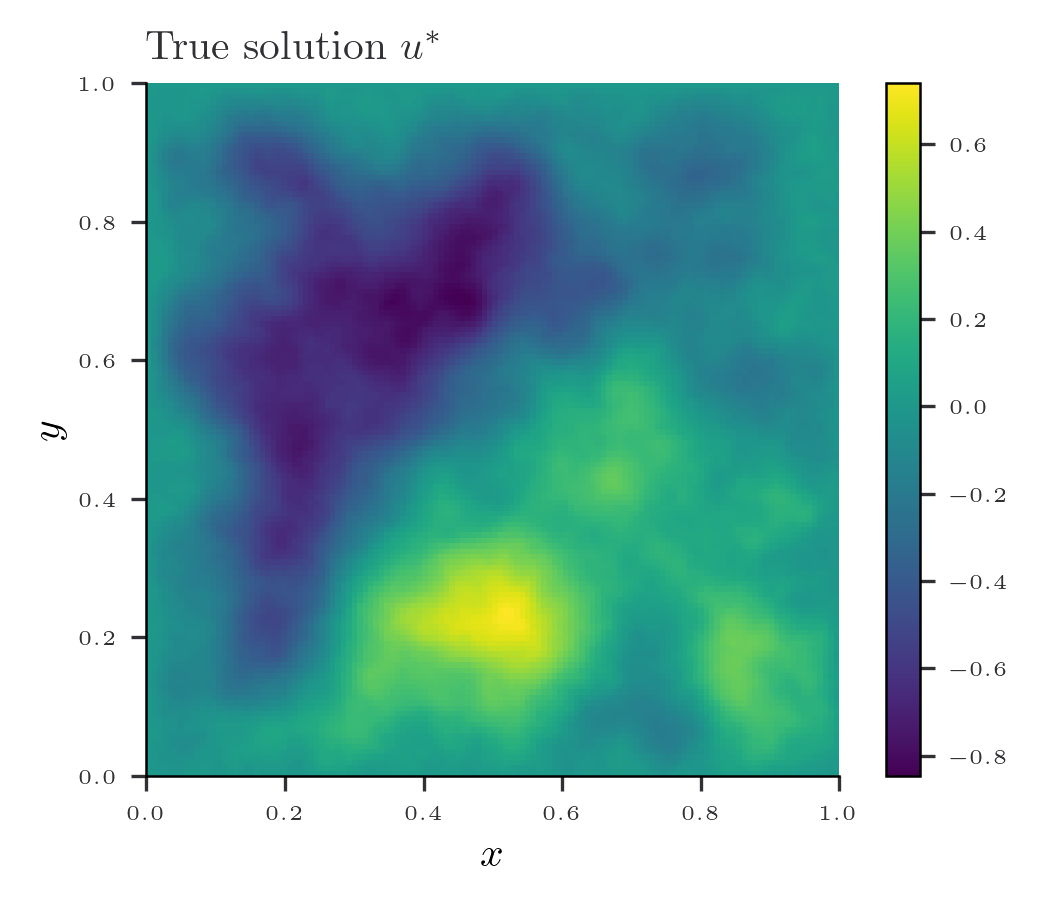

In [123]:
fig = plt.figure(figsize=(width, height))

plt.imshow(u_values, cmap='viridis', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'True solution $u^*$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

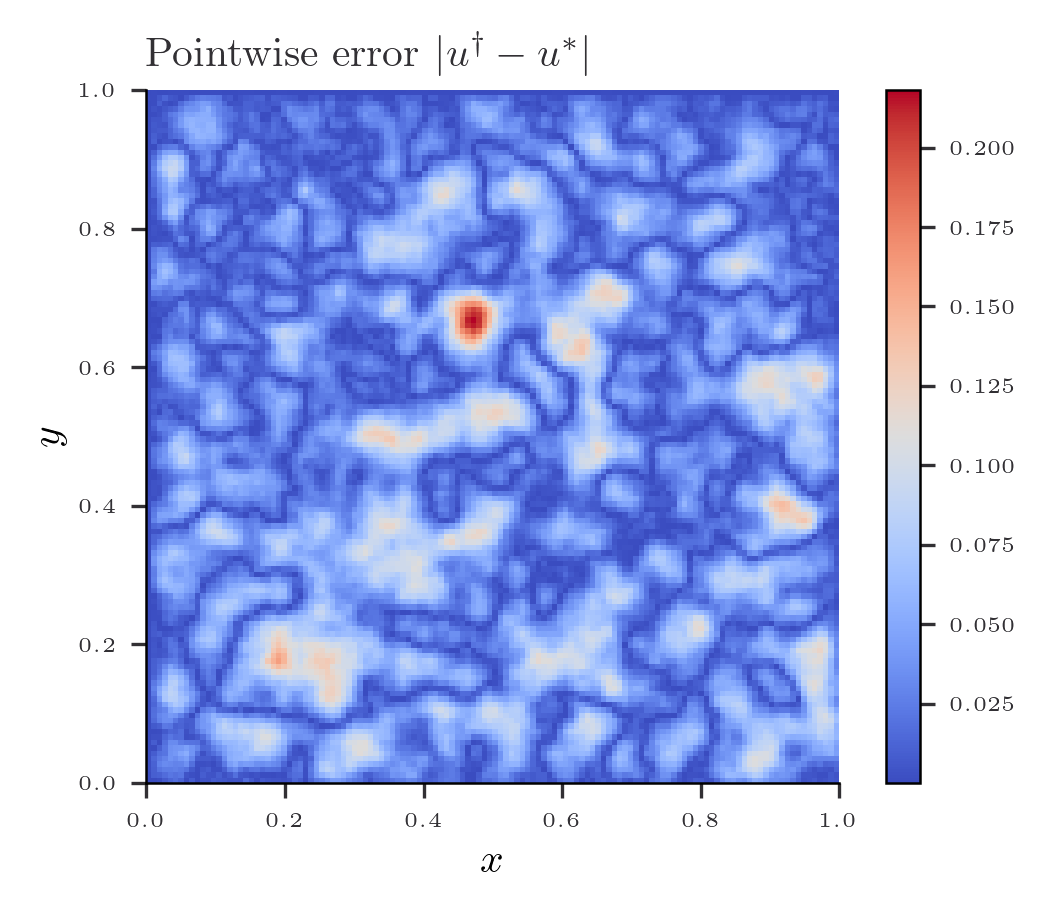

In [124]:
fig = plt.figure(figsize=(width, height))

plt.imshow(jnp.abs(pred_grid - u_values), cmap='coolwarm', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Pointwise error $|u^\dagger - u^*|$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()